In [1]:
import os
import csv

# get current working directory
os.getcwd()

'c:\\Users\\pnaghs1\\OneDrive - Louisiana State University\\github\\Conductivity_GCN\\notebooks\\codes'

## xgboost


In [5]:
# ==========================================
# 🔥 XGBoost Regression + Optuna + Ablation
# ==========================================

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import optuna
import matplotlib.pyplot as plt

# ==========================================
# 1️⃣ Load dataset
# ==========================================
data = pd.read_csv("../../data/full_descriptor_data.csv")

target_col = data.columns[-1]
X = data.drop(columns=[target_col])
y = data[target_col]

# ==========================================
# 2️⃣ Standardize + PCA
# ==========================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.80, random_state=2023)
X_pca = pca.fit_transform(X_scaled)

print(f"✅ PCA selected {pca.n_components_} components explaining {pca.explained_variance_ratio_.sum():.2f} variance.")

# ==========================================
# 3️⃣ Split data
# ==========================================
X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(
    X_pca, y, test_size=0.1, random_state=2023
)

# ==========================================
# 4️⃣ Optuna Objective
# ==========================================
def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1200),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 3),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 3),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state":2023,
        "n_jobs": -1,
        "objective": "reg:squarederror"
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=2023)
    r2_scores = []

    for train_idx, val_idx in kf.split(X_train_full):
        X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
        y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        model = XGBRegressor(**params)
        model.fit(X_train, y_train, verbose=False)
        y_pred = model.predict(X_val)
        r2_scores.append(r2_score(y_val, y_pred))

    return np.mean(r2_scores)

# ==========================================
# 5️⃣ Run optimization
# ==========================================
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=20, show_progress_bar=True)

# ==========================================
# 6️⃣ Evaluate best model
# ==========================================
print("\n🎯 Best parameters (XGBoost):")
for k, v in study_xgb.best_params.items():
    print(f"{k}: {v}")
print(f"✅ Best mean CV R²: {study_xgb.best_value:.4f}")

best_model_xgb = XGBRegressor(**study_xgb.best_params, n_jobs=-1)
best_model_xgb.fit(X_train_full, y_train_full)
y_pred_final = best_model_xgb.predict(X_test_final)

r2 = r2_score(y_test_final, y_pred_final)
mae = mean_absolute_error(y_test_final, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test_final, y_pred_final))

print("\n🧾 Final XGBoost Evaluation:")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# ==========================================
# 7️⃣ Ablation Analysis on PCA Components
# ==========================================
ablation_results = []
best_params = study_xgb.best_params

for i in range(X_train_full.shape[1]):
    X_train_ablate = np.delete(X_train_full, i, axis=1)
    X_test_ablate = np.delete(X_test_final, i, axis=1)
    
    model = XGBRegressor(**best_params, n_jobs=-1)
    model.fit(X_train_ablate, y_train_full)
    y_pred_ablate = model.predict(X_test_ablate)
    r2_ablate = r2_score(y_test_final, y_pred_ablate)
    ablation_results.append(r2_ablate)
    print(f"Removed PC{i+1} → R²: {r2_ablate:.4f}")

# ==========================================
# 8️⃣ Plot Ablation Results (Vertical Bar)
# ==========================================
plt.figure(figsize=(7,5))
bars = plt.bar(range(1, len(ablation_results)+1), ablation_results, color="darkorange", edgecolor="black")

for i, val in enumerate(ablation_results):
    plt.text(i+1, val + 0.005, f"{val:.3f}", ha="center", fontsize=10)

plt.xticks(range(1, len(ablation_results)+1), [f"PC{i}" for i in range(1, len(ablation_results)+1)])
plt.xlabel("Removed PCA Component", fontsize=12)
plt.ylabel("R² Score on Test Set", fontsize=12)
plt.title("Ablation Analysis — PCA Component Importance (XGBoost)", fontsize=14)
plt.tight_layout()
plt.show()

[I 2025-10-28 14:59:25,347] A new study created in memory with name: no-name-22f2c777-0588-400c-aeea-9e77bfcc1b29


✅ PCA selected 8 components explaining 0.81 variance.


Best trial: 0. Best value: 0.495765:   5%|▌         | 1/20 [00:03<00:59,  3.11s/it]

[I 2025-10-28 14:59:28,453] Trial 0 finished with value: 0.4957649157123766 and parameters: {'n_estimators': 1112, 'max_depth': 10, 'learning_rate': 0.010010339220203782, 'subsample': 0.7413755435256784, 'colsample_bytree': 0.7854771061216281, 'reg_lambda': 1.1379571708730776, 'reg_alpha': 0.13310047553038307, 'min_child_weight': 9}. Best is trial 0 with value: 0.4957649157123766.


Best trial: 0. Best value: 0.495765:  10%|█         | 2/20 [00:03<00:31,  1.76s/it]

[I 2025-10-28 14:59:29,266] Trial 1 finished with value: -0.040288989206655176 and parameters: {'n_estimators': 766, 'max_depth': 9, 'learning_rate': 0.024629487820785993, 'subsample': 0.9657176134597696, 'colsample_bytree': 0.7359921919254283, 'reg_lambda': 2.508981974051445, 'reg_alpha': 1.6767208930478765, 'min_child_weight': 3}. Best is trial 0 with value: 0.4957649157123766.


Best trial: 0. Best value: 0.495765:  15%|█▌        | 3/20 [00:05<00:25,  1.50s/it]

[I 2025-10-28 14:59:30,452] Trial 2 finished with value: -0.040288989206655176 and parameters: {'n_estimators': 946, 'max_depth': 3, 'learning_rate': 0.07677404411282394, 'subsample': 0.953421239844946, 'colsample_bytree': 0.995671620423092, 'reg_lambda': 0.6977314669635966, 'reg_alpha': 2.577921786329048, 'min_child_weight': 8}. Best is trial 0 with value: 0.4957649157123766.


Best trial: 0. Best value: 0.495765:  20%|██        | 4/20 [00:05<00:18,  1.13s/it]

[I 2025-10-28 14:59:31,034] Trial 3 finished with value: 0.04097550747891372 and parameters: {'n_estimators': 457, 'max_depth': 9, 'learning_rate': 0.06808088631812463, 'subsample': 0.9668017878204074, 'colsample_bytree': 0.9307564963482113, 'reg_lambda': 0.8422417740016287, 'reg_alpha': 1.195989477205569, 'min_child_weight': 7}. Best is trial 0 with value: 0.4957649157123766.


Best trial: 0. Best value: 0.495765:  25%|██▌       | 5/20 [00:06<00:13,  1.08it/s]

[I 2025-10-28 14:59:31,587] Trial 4 finished with value: 0.32414332689466613 and parameters: {'n_estimators': 393, 'max_depth': 3, 'learning_rate': 0.08276611301955991, 'subsample': 0.656570033187327, 'colsample_bytree': 0.8646814856531936, 'reg_lambda': 0.7367155056599811, 'reg_alpha': 0.49826394698380694, 'min_child_weight': 7}. Best is trial 0 with value: 0.4957649157123766.


Best trial: 0. Best value: 0.495765:  30%|███       | 6/20 [00:07<00:15,  1.12s/it]

[I 2025-10-28 14:59:33,089] Trial 5 finished with value: 0.03452454344625011 and parameters: {'n_estimators': 812, 'max_depth': 10, 'learning_rate': 0.010125436679081326, 'subsample': 0.822955234690569, 'colsample_bytree': 0.8180212878477504, 'reg_lambda': 1.1644775752828496, 'reg_alpha': 1.1465541424453045, 'min_child_weight': 1}. Best is trial 0 with value: 0.4957649157123766.


Best trial: 0. Best value: 0.495765:  35%|███▌      | 7/20 [00:09<00:15,  1.17s/it]

[I 2025-10-28 14:59:34,351] Trial 6 finished with value: -0.040288989206655176 and parameters: {'n_estimators': 734, 'max_depth': 6, 'learning_rate': 0.07448892569313677, 'subsample': 0.79506161825489, 'colsample_bytree': 0.6515383319865259, 'reg_lambda': 1.0653916642610763, 'reg_alpha': 2.645084843399742, 'min_child_weight': 6}. Best is trial 0 with value: 0.4957649157123766.


Best trial: 0. Best value: 0.495765:  40%|████      | 8/20 [00:11<00:17,  1.46s/it]

[I 2025-10-28 14:59:36,443] Trial 7 finished with value: 0.29998405300285436 and parameters: {'n_estimators': 1109, 'max_depth': 8, 'learning_rate': 0.01664242543652398, 'subsample': 0.804464047354142, 'colsample_bytree': 0.6025864508100666, 'reg_lambda': 1.6812296105847575, 'reg_alpha': 0.5440500789270859, 'min_child_weight': 8}. Best is trial 0 with value: 0.4957649157123766.


Best trial: 0. Best value: 0.495765:  45%|████▌     | 9/20 [00:12<00:15,  1.38s/it]

[I 2025-10-28 14:59:37,655] Trial 8 finished with value: 0.1696786427885166 and parameters: {'n_estimators': 933, 'max_depth': 7, 'learning_rate': 0.19805275927437302, 'subsample': 0.9374487318300233, 'colsample_bytree': 0.9295549067805038, 'reg_lambda': 1.7398785737411941, 'reg_alpha': 0.9676204928193425, 'min_child_weight': 3}. Best is trial 0 with value: 0.4957649157123766.


Best trial: 0. Best value: 0.495765:  50%|█████     | 10/20 [00:13<00:13,  1.34s/it]

[I 2025-10-28 14:59:38,908] Trial 9 finished with value: -0.03628587547758579 and parameters: {'n_estimators': 871, 'max_depth': 3, 'learning_rate': 0.040064318879618206, 'subsample': 0.9532539036531804, 'colsample_bytree': 0.8468137960064435, 'reg_lambda': 0.5873035188040824, 'reg_alpha': 1.4819154141237743, 'min_child_weight': 3}. Best is trial 0 with value: 0.4957649157123766.


Best trial: 10. Best value: 0.500431:  55%|█████▌    | 11/20 [00:16<00:15,  1.77s/it]

[I 2025-10-28 14:59:41,645] Trial 10 finished with value: 0.500430889784367 and parameters: {'n_estimators': 1177, 'max_depth': 5, 'learning_rate': 0.22787209384484022, 'subsample': 0.604684053074996, 'colsample_bytree': 0.7130519165444452, 'reg_lambda': 0.21256476855995787, 'reg_alpha': 0.0854579798509181, 'min_child_weight': 10}. Best is trial 10 with value: 0.500430889784367.


Best trial: 11. Best value: 0.500697:  60%|██████    | 12/20 [00:19<00:16,  2.12s/it]

[I 2025-10-28 14:59:44,562] Trial 11 finished with value: 0.5006969029525544 and parameters: {'n_estimators': 1195, 'max_depth': 5, 'learning_rate': 0.28334552504885213, 'subsample': 0.6003844974476035, 'colsample_bytree': 0.7300236786662848, 'reg_lambda': 0.13478093767284288, 'reg_alpha': 0.07504195534635073, 'min_child_weight': 10}. Best is trial 11 with value: 0.5006969029525544.


Best trial: 11. Best value: 0.500697:  65%|██████▌   | 13/20 [00:21<00:14,  2.10s/it]

[I 2025-10-28 14:59:46,631] Trial 12 finished with value: 0.47092589263065554 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'learning_rate': 0.29601849012791015, 'subsample': 0.6032676185031942, 'colsample_bytree': 0.7062437213967663, 'reg_lambda': 0.07577299356673474, 'reg_alpha': 0.14930874136573014, 'min_child_weight': 10}. Best is trial 11 with value: 0.5006969029525544.


Best trial: 13. Best value: 0.513071:  70%|███████   | 14/20 [00:22<00:10,  1.71s/it]

[I 2025-10-28 14:59:47,419] Trial 13 finished with value: 0.5130714334033252 and parameters: {'n_estimators': 226, 'max_depth': 5, 'learning_rate': 0.15468151506466424, 'subsample': 0.6052241517564114, 'colsample_bytree': 0.7169790894395687, 'reg_lambda': 0.07093364021327782, 'reg_alpha': 0.009658853088998456, 'min_child_weight': 10}. Best is trial 13 with value: 0.5130714334033252.


Best trial: 13. Best value: 0.513071:  75%|███████▌  | 15/20 [00:22<00:06,  1.33s/it]

[I 2025-10-28 14:59:47,867] Trial 14 finished with value: 0.27220622305165865 and parameters: {'n_estimators': 255, 'max_depth': 5, 'learning_rate': 0.20612655943934835, 'subsample': 0.684355308727473, 'colsample_bytree': 0.7657580382901221, 'reg_lambda': 0.06518672438539243, 'reg_alpha': 0.6242369291629306, 'min_child_weight': 10}. Best is trial 13 with value: 0.5130714334033252.


Best trial: 13. Best value: 0.513071:  80%|████████  | 16/20 [00:23<00:04,  1.15s/it]

[I 2025-10-28 14:59:48,614] Trial 15 finished with value: -0.040288989206655176 and parameters: {'n_estimators': 560, 'max_depth': 4, 'learning_rate': 0.12879789813992804, 'subsample': 0.6722684313295092, 'colsample_bytree': 0.6677786335273741, 'reg_lambda': 2.4499373046605735, 'reg_alpha': 2.0808599161288592, 'min_child_weight': 5}. Best is trial 13 with value: 0.5130714334033252.


Best trial: 13. Best value: 0.513071:  85%|████████▌ | 17/20 [00:24<00:03,  1.09s/it]

[I 2025-10-28 14:59:49,540] Trial 16 finished with value: 0.2416144016144087 and parameters: {'n_estimators': 621, 'max_depth': 6, 'learning_rate': 0.1304043942844403, 'subsample': 0.7288598351319423, 'colsample_bytree': 0.6654267530562608, 'reg_lambda': 0.4306375991518508, 'reg_alpha': 0.7160294891396815, 'min_child_weight': 9}. Best is trial 13 with value: 0.5130714334033252.


Best trial: 17. Best value: 0.613562:  90%|█████████ | 18/20 [00:25<00:02,  1.10s/it]

[I 2025-10-28 14:59:50,662] Trial 17 finished with value: 0.6135620750657452 and parameters: {'n_estimators': 235, 'max_depth': 7, 'learning_rate': 0.13107795983426995, 'subsample': 0.6445351023279628, 'colsample_bytree': 0.7520038198137065, 'reg_lambda': 2.933032036942413, 'reg_alpha': 0.0030729152868208126, 'min_child_weight': 5}. Best is trial 17 with value: 0.6135620750657452.


Best trial: 17. Best value: 0.613562:  95%|█████████▌| 19/20 [00:25<00:00,  1.13it/s]

[I 2025-10-28 14:59:51,051] Trial 18 finished with value: -0.040288989206655176 and parameters: {'n_estimators': 234, 'max_depth': 7, 'learning_rate': 0.1259838426381884, 'subsample': 0.8972972807983347, 'colsample_bytree': 0.6087844462226074, 'reg_lambda': 2.7984864534786946, 'reg_alpha': 2.1069630261442045, 'min_child_weight': 5}. Best is trial 17 with value: 0.6135620750657452.


Best trial: 17. Best value: 0.613562: 100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


[I 2025-10-28 14:59:52,024] Trial 19 finished with value: 0.38702554984418774 and parameters: {'n_estimators': 348, 'max_depth': 8, 'learning_rate': 0.0468737579689529, 'subsample': 0.7209746895849121, 'colsample_bytree': 0.8141488614714457, 'reg_lambda': 2.0702024478479375, 'reg_alpha': 0.4143078807681324, 'min_child_weight': 4}. Best is trial 17 with value: 0.6135620750657452.

🎯 Best parameters (XGBoost):
n_estimators: 235
max_depth: 7
learning_rate: 0.13107795983426995
subsample: 0.6445351023279628
colsample_bytree: 0.7520038198137065
reg_lambda: 2.933032036942413
reg_alpha: 0.0030729152868208126
min_child_weight: 5
✅ Best mean CV R²: 0.6136

🧾 Final XGBoost Evaluation:
R²: 0.8445
MAE: 0.0158
RMSE: 0.0195
Removed PC1 → R²: 0.8209
Removed PC2 → R²: 0.8075
Removed PC3 → R²: 0.8329
Removed PC4 → R²: 0.8394
Removed PC5 → R²: 0.8330
Removed PC6 → R²: 0.8581
Removed PC7 → R²: 0.8512
Removed PC8 → R²: 0.8559


In [6]:
# ==========================================
# 🔹 Parity Plot (Predicted vs Actual)
# ==========================================
plt.figure(figsize=(6, 6))
plt.scatter(y_test_final, y_pred_final, alpha=0.7, edgecolors="k")
lo, hi = min(y_test_final.min(), y_pred_final.min()), max(y_test_final.max(), y_pred_final.max())
plt.plot([lo, hi], [lo, hi], "r--")
plt.xlabel("True Conductivity [S/cm]", fontsize=12)
plt.ylabel("Predicted Conductivity [S/cm]", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Removed PC1 → R²: 0.8209
Removed PC2 → R²: 0.8075
Removed PC3 → R²: 0.8329
Removed PC4 → R²: 0.8394
Removed PC5 → R²: 0.8330
Removed PC6 → R²: 0.8581
Removed PC7 → R²: 0.8512
Removed PC8 → R²: 0.8559


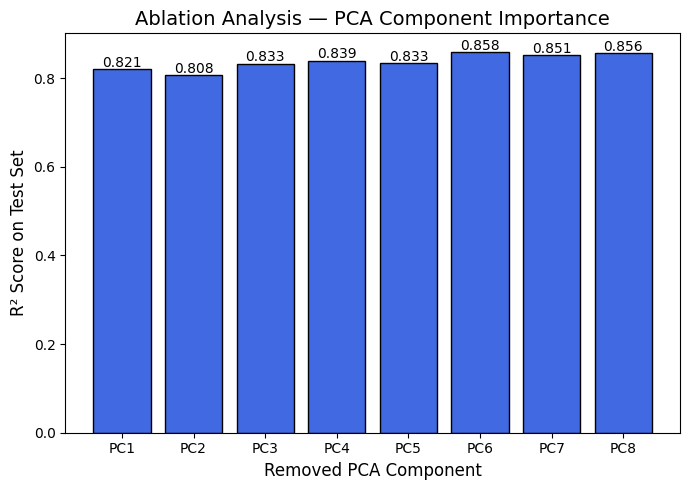

In [7]:
# ==========================================
# 🔍  Ablation Analysis on PCA Components
# ==========================================
ablation_results = []

# Use best RF parameters found by Optuna
best_params = study_xgb.best_params

for i in range(X_train_full.shape[1]):  # loop through PCA components
    # Drop the i-th PCA component
    X_train_ablate = np.delete(X_train_full, i, axis=1)
    X_test_ablate = np.delete(X_test_final, i, axis=1)
    
    # Retrain and evaluate
    model = XGBRegressor(**best_params, n_jobs=-1)
    model.fit(X_train_ablate, y_train_full)
    y_pred_ablate = model.predict(X_test_ablate)
    r2_ablate = r2_score(y_test_final, y_pred_ablate)
    
    ablation_results.append(r2_ablate)
    print(f"Removed PC{i+1} → R²: {r2_ablate:.4f}")

# Convert to DataFrame
ablation_df = pd.DataFrame({
    "PCA_Component_Removed": [f"PC{i+1}" for i in range(len(ablation_results))],
    "R2_Score": ablation_results
})

# ==========================================
# 📊  Plot Ablation Results (Vertical)
# ==========================================
plt.figure(figsize=(7,5))
bars = plt.bar(range(1, len(ablation_results)+1), ablation_results, color="royalblue", edgecolor="black")

# Annotate R² values above bars
for i, val in enumerate(ablation_results):
    plt.text(i+1, val + 0.005, f"{val:.3f}", ha="center", fontsize=10)

plt.xticks(range(1, len(ablation_results)+1), [f"PC{i}" for i in range(1, len(ablation_results)+1)])
plt.xlabel("Removed PCA Component", fontsize=12)
plt.ylabel("R² Score on Test Set", fontsize=12)
plt.title("Ablation Analysis — PCA Component Importance", fontsize=14)
plt.tight_layout()
plt.show()


In [8]:
import pandas as pd
import numpy as np

# Suppose you already have PCA and the standardized data
# pca = PCA(n_components=0.80, random_state=42)
# X_scaled = scaler.fit_transform(X)
# pca.fit(X_scaled)

# Create a DataFrame for PCA loadings (each column = PC, each row = descriptor)
loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# Find top 10 contributing descriptors for each PC
top_loadings = {}
for pc in loadings.columns:
    top_features = (
        loadings[pc]
        .abs()
        .sort_values(ascending=False)
        .head(10)
        .index.tolist()
    )
    top_loadings[pc] = top_features

# Display top descriptors per component
for pc, features in top_loadings.items():
    print(f"\n🧭 {pc} — Top Contributing Descriptors:")
    print(", ".join(features))



🧭 PC1 — Top Contributing Descriptors:
ETA_beta, MPC7, ATS2m, MPC4, MPC3, ATS2s, BertzCT, Xp-7d, MPC5, TMPC10

🧭 PC2 — Top Contributing Descriptors:
FCSP3, HybRatio, Mp, AATS0p, AATS0v, GATS1v, AETA_beta_ns, AETA_beta, AETA_dBeta, Mv

🧭 PC3 — Top Contributing Descriptors:
ATSC1pe, VSA_EState4, ATSC1se, AATS6i, AATSC6c, ATSC1are, AATS0i, Mi, SaasC, ATSC1m

🧭 PC4 — Top Contributing Descriptors:
GATS3i, AATSC3p, MATS3p, AATSC3v, AATSC2v, MATS2v, GATS3p, MATS3v, GATS4i, MATS3i

🧭 PC5 — Top Contributing Descriptors:
AATSC8dv, MATS8dv, MATS5pe, AATSC5dv, GATS8dv, GATS5dv, MATS5dv, AATSC8Z, AATSC8m, MATS5are

🧭 PC6 — Top Contributing Descriptors:
GATS1d, MATS1d, MATS4d, AATSC4d, GATS4d, GATS3se, AATSC1d, nG12FAHRing, MATS2s, MATS4pe

🧭 PC7 — Top Contributing Descriptors:
GATS7d, AATSC6i, MATS6p, AATSC8i, AATSC6p, GATS1dv, MATS1s, AATSC8p, AATSC1dv, MATS8p

🧭 PC8 — Top Contributing Descriptors:
AATSC1p, AMID_C, MATS1p, GATS6dv, JGI5, AATSC6dv, AMID_h, AATSC1v, MATS6d, MATS6dv


In [9]:
explained = pca.explained_variance_ratio_
for i, var in enumerate(explained):
    print(f"PC{i+1}: {var*100:.2f}% variance")


PC1: 42.41% variance
PC2: 12.13% variance
PC3: 6.77% variance
PC4: 5.71% variance
PC5: 4.19% variance
PC6: 3.67% variance
PC7: 3.36% variance
PC8: 2.30% variance


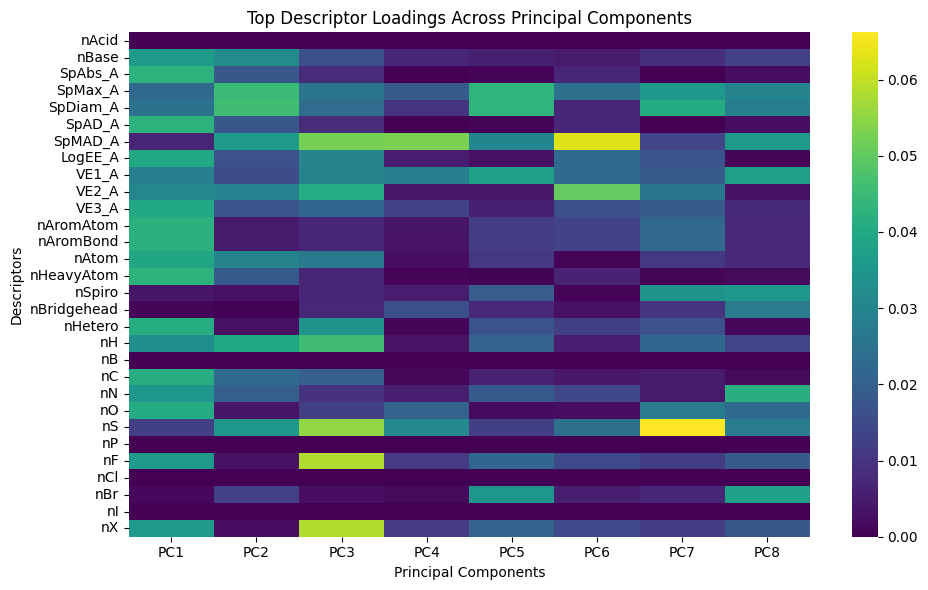

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(loadings.abs().head(30), cmap="viridis")
plt.title("Top Descriptor Loadings Across Principal Components")
plt.xlabel("Principal Components")
plt.ylabel("Descriptors")
plt.tight_layout()
plt.show()


### random forest 

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import optuna
import matplotlib.pyplot as plt

# ==========================================
# 1️⃣ Load dataset
# ==========================================
data = pd.read_csv("../../data/full_descriptor_data.csv")

target_col = data.columns[-1]
X = data.drop(columns=[target_col])
y = data[target_col]

# ==========================================
# 2️⃣ Standardize + PCA
# ==========================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.80, random_state=2023)
X_pca = pca.fit_transform(X_scaled)

print(f"✅ PCA selected {pca.n_components_} components explaining {pca.explained_variance_ratio_.sum():.2f} variance.")

# ==========================================
# 3️⃣ Split data
# ==========================================
X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(
    X_pca, y, test_size=0.1, random_state=2023
)

# ==========================================
# 4️⃣ Optuna Objective
# ==========================================
def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "random_state": 2023,
        "n_jobs": -1
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=2023)
    r2_scores = []

    for train_idx, val_idx in kf.split(X_train_full):
        X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
        y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        r2_scores.append(r2_score(y_val, y_pred))

    return np.mean(r2_scores)

# ==========================================
# 5️⃣ Run optimization
# ==========================================
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=20, show_progress_bar=True)

# ==========================================
# 6️⃣ Evaluate best model
# ==========================================
print("\n🎯 Best parameters (Random Forest):")
for k, v in study_rf.best_params.items():
    print(f"{k}: {v}")
print(f"✅ Best mean CV R²: {study_rf.best_value:.4f}")

best_model_rf = RandomForestRegressor(**study_rf.best_params, n_jobs=-1)
best_model_rf.fit(X_train_full, y_train_full)
y_pred_final = best_model_rf.predict(X_test_final)

r2 = r2_score(y_test_final, y_pred_final)
mae = mean_absolute_error(y_test_final, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test_final, y_pred_final))

print("\n🧾 Final Random Forest Evaluation:")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


[I 2025-10-28 15:03:23,995] A new study created in memory with name: no-name-2904df5a-47c7-4447-a72a-0c4fe3524ef7


✅ PCA selected 8 components explaining 0.81 variance.


Best trial: 0. Best value: 0.510249:   5%|▌         | 1/20 [00:00<00:18,  1.02it/s]

[I 2025-10-28 15:03:24,992] Trial 0 finished with value: 0.5102494174760706 and parameters: {'n_estimators': 250, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.5102494174760706.


Best trial: 1. Best value: 0.554478:  10%|█         | 2/20 [00:02<00:27,  1.52s/it]

[I 2025-10-28 15:03:26,890] Trial 1 finished with value: 0.5544781877563701 and parameters: {'n_estimators': 478, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.5544781877563701.


Best trial: 1. Best value: 0.554478:  15%|█▌        | 3/20 [00:04<00:26,  1.53s/it]

[I 2025-10-28 15:03:28,441] Trial 2 finished with value: 0.5138802184537912 and parameters: {'n_estimators': 392, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.5544781877563701.


Best trial: 3. Best value: 0.624724:  20%|██        | 4/20 [00:05<00:22,  1.40s/it]

[I 2025-10-28 15:03:29,646] Trial 3 finished with value: 0.624724356501491 and parameters: {'n_estimators': 403, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 3 with value: 0.624724356501491.


Best trial: 3. Best value: 0.624724:  25%|██▌       | 5/20 [00:07<00:23,  1.59s/it]

[I 2025-10-28 15:03:31,578] Trial 4 finished with value: 0.5316793443516135 and parameters: {'n_estimators': 716, 'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': False}. Best is trial 3 with value: 0.624724356501491.


Best trial: 3. Best value: 0.624724:  30%|███       | 6/20 [00:09<00:22,  1.62s/it]

[I 2025-10-28 15:03:33,243] Trial 5 finished with value: 0.5137840414661432 and parameters: {'n_estimators': 364, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 3 with value: 0.624724356501491.


Best trial: 3. Best value: 0.624724:  35%|███▌      | 7/20 [00:11<00:21,  1.69s/it]

[I 2025-10-28 15:03:35,082] Trial 6 finished with value: 0.558359802170912 and parameters: {'n_estimators': 614, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 3 with value: 0.624724356501491.


Best trial: 3. Best value: 0.624724:  40%|████      | 8/20 [00:12<00:18,  1.53s/it]

[I 2025-10-28 15:03:36,264] Trial 7 finished with value: 0.5393748365914374 and parameters: {'n_estimators': 278, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 3 with value: 0.624724356501491.


Best trial: 3. Best value: 0.624724:  45%|████▌     | 9/20 [00:13<00:14,  1.31s/it]

[I 2025-10-28 15:03:37,082] Trial 8 finished with value: 0.5892863153494554 and parameters: {'n_estimators': 268, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 3 with value: 0.624724356501491.


Best trial: 3. Best value: 0.624724:  50%|█████     | 10/20 [00:14<00:12,  1.25s/it]

[I 2025-10-28 15:03:38,215] Trial 9 finished with value: 0.5530569147005473 and parameters: {'n_estimators': 388, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 3 with value: 0.624724356501491.


Best trial: 3. Best value: 0.624724:  55%|█████▌    | 11/20 [00:15<00:12,  1.38s/it]

[I 2025-10-28 15:03:39,898] Trial 10 finished with value: 0.2173806780746254 and parameters: {'n_estimators': 567, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': False}. Best is trial 3 with value: 0.624724356501491.


Best trial: 3. Best value: 0.624724:  60%|██████    | 12/20 [00:16<00:09,  1.17s/it]

[I 2025-10-28 15:03:40,585] Trial 11 finished with value: 0.5559091483412335 and parameters: {'n_estimators': 214, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 3 with value: 0.624724356501491.


Best trial: 3. Best value: 0.624724:  65%|██████▌   | 13/20 [00:17<00:07,  1.14s/it]

[I 2025-10-28 15:03:41,632] Trial 12 finished with value: 0.589967520339721 and parameters: {'n_estimators': 324, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 3 with value: 0.624724356501491.


Best trial: 3. Best value: 0.624724:  70%|███████   | 14/20 [00:19<00:07,  1.22s/it]

[I 2025-10-28 15:03:43,033] Trial 13 finished with value: 0.22025773107282443 and parameters: {'n_estimators': 473, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': False}. Best is trial 3 with value: 0.624724356501491.


Best trial: 3. Best value: 0.624724:  75%|███████▌  | 15/20 [00:20<00:05,  1.18s/it]

[I 2025-10-28 15:03:44,135] Trial 14 finished with value: 0.6232825774650658 and parameters: {'n_estimators': 357, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 3 with value: 0.624724356501491.


Best trial: 3. Best value: 0.624724:  80%|████████  | 16/20 [00:21<00:04,  1.21s/it]

[I 2025-10-28 15:03:45,419] Trial 15 finished with value: 0.6201521052707013 and parameters: {'n_estimators': 434, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 3 with value: 0.624724356501491.


Best trial: 3. Best value: 0.624724:  85%|████████▌ | 17/20 [00:23<00:04,  1.37s/it]

[I 2025-10-28 15:03:47,139] Trial 16 finished with value: 0.5880865799926461 and parameters: {'n_estimators': 565, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 3 with value: 0.624724356501491.


Best trial: 3. Best value: 0.624724:  90%|█████████ | 18/20 [00:25<00:03,  1.65s/it]

[I 2025-10-28 15:03:49,458] Trial 17 finished with value: 0.20977953748980047 and parameters: {'n_estimators': 755, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': False}. Best is trial 3 with value: 0.624724356501491.


Best trial: 3. Best value: 0.624724:  95%|█████████▌| 19/20 [00:26<00:01,  1.59s/it]

[I 2025-10-28 15:03:50,909] Trial 18 finished with value: 0.599371794819137 and parameters: {'n_estimators': 339, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 3 with value: 0.624724356501491.


Best trial: 3. Best value: 0.624724: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


[I 2025-10-28 15:03:52,574] Trial 19 finished with value: 0.6144229279735184 and parameters: {'n_estimators': 531, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 3 with value: 0.624724356501491.

🎯 Best parameters (Random Forest):
n_estimators: 403
max_depth: 30
min_samples_split: 4
min_samples_leaf: 2
max_features: sqrt
bootstrap: False
✅ Best mean CV R²: 0.6247

🧾 Final Random Forest Evaluation:
R²: 0.8477
MAE: 0.0161
RMSE: 0.0193


In [13]:
# ==========================================
# 🔹 Parity Plot (Predicted vs Actual)
# ==========================================
plt.figure(figsize=(6, 6))
plt.scatter(y_test_final, y_pred_final, alpha=0.7, edgecolors="k")
lo, hi = min(y_test_final.min(), y_pred_final.min()), max(y_test_final.max(), y_pred_final.max())
plt.plot([lo, hi], [lo, hi], "r--")
plt.xlabel("True Conductivity [S/cm]", fontsize=12)
plt.ylabel("Predicted Conductivity [S/cm]", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [14]:
# ==========================================
# 🔍  Ablation Analysis on PCA Components
# ==========================================
ablation_results = []

# Use best RF parameters found by Optuna
best_params = study_rf.best_params

for i in range(X_train_full.shape[1]):  # loop through PCA components
    # Drop the i-th PCA component
    X_train_ablate = np.delete(X_train_full, i, axis=1)
    X_test_ablate = np.delete(X_test_final, i, axis=1)
    
    # Retrain and evaluate
    model = RandomForestRegressor(**best_params, n_jobs=-1)
    model.fit(X_train_ablate, y_train_full)
    y_pred_ablate = model.predict(X_test_ablate)
    r2_ablate = r2_score(y_test_final, y_pred_ablate)
    
    ablation_results.append(r2_ablate)
    print(f"Removed PC{i+1} → R²: {r2_ablate:.4f}")

# Convert to DataFrame
ablation_df = pd.DataFrame({
    "PCA_Component_Removed": [f"PC{i+1}" for i in range(len(ablation_results))],
    "R2_Score": ablation_results
})

# ==========================================
# 📊  Plot Ablation Results (Vertical)
# ==========================================
plt.figure(figsize=(7,5))
bars = plt.bar(range(1, len(ablation_results)+1), ablation_results, color="royalblue", edgecolor="black")

# Annotate R² values above bars
for i, val in enumerate(ablation_results):
    plt.text(i+1, val + 0.005, f"{val:.3f}", ha="center", fontsize=10)

plt.xticks(range(1, len(ablation_results)+1), [f"PC{i}" for i in range(1, len(ablation_results)+1)])
plt.xlabel("Removed PCA Component", fontsize=12)
plt.ylabel("R² Score on Test Set", fontsize=12)
plt.title("Ablation Analysis — PCA Component Importance", fontsize=14)
plt.tight_layout()
plt.show()


Removed PC1 → R²: 0.8478
Removed PC2 → R²: 0.8530
Removed PC3 → R²: 0.8565
Removed PC4 → R²: 0.8486
Removed PC5 → R²: 0.8558
Removed PC6 → R²: 0.8214
Removed PC7 → R²: 0.8418
Removed PC8 → R²: 0.8558


## catboost

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
import optuna
import matplotlib.pyplot as plt
from collections import defaultdict

# ==========================================
# 1️⃣ Load dataset
# ==========================================
data = pd.read_csv("../../data/full_descriptor_data.csv")

target_col = data.columns[-1]
X = data.drop(columns=[target_col])
y = data[target_col]

# ==========================================
# 2️⃣ Standardize + PCA
# ==========================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.80, random_state=2023)
X_pca = pca.fit_transform(X_scaled)

print(f"✅ PCA selected {pca.n_components_} components explaining {pca.explained_variance_ratio_.sum():.2f} variance.")

# ==========================================
# 3️⃣ Split data
# ==========================================
X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(
    X_pca, y, test_size=0.1, random_state=2023
)

# ==========================================
# 4️⃣ Optuna Objective
# ==========================================
def objective_cat(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 200, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_strength": trial.suggest_float("random_strength", 0.0, 2.0),
        "border_count": trial.suggest_int("border_count", 32, 254),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "rsm": trial.suggest_float("rsm", 0.6, 1.0),
        "loss_function": "RMSE",
        "verbose": False,
        "random_seed": 2023,
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=2023)
    r2_scores = []

    for train_idx, val_idx in kf.split(X_train_full):
        X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
        y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        model = CatBoostRegressor(**params)
        model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
        y_pred = model.predict(X_val)
        r2_scores.append(r2_score(y_val, y_pred))

    return np.mean(r2_scores)

# ==========================================
# 5️⃣ Run optimization
# ==========================================
study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(objective_cat, n_trials=20, show_progress_bar=True)

# ==========================================
# 6️⃣ Evaluate best model
# ==========================================
print("\n🎯 Best parameters (CatBoost):")
for k, v in study_cat.best_params.items():
    print(f"{k}: {v}")
print(f"✅ Best mean CV R²: {study_cat.best_value:.4f}")

best_model_cat = CatBoostRegressor(**study_cat.best_params, verbose=False, random_seed=2023)
best_model_cat.fit(X_train_full, y_train_full)
y_pred_final = best_model_cat.predict(X_test_final)

r2 = r2_score(y_test_final, y_pred_final)
mae = mean_absolute_error(y_test_final, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test_final, y_pred_final))

print("\n🧾 Final CatBoost Evaluation:")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


[I 2025-10-28 15:04:23,383] A new study created in memory with name: no-name-788809b3-c25b-4b87-aca2-f0b60e6586ce


✅ PCA selected 8 components explaining 0.81 variance.


Best trial: 0. Best value: 0.59348:   5%|▌         | 1/20 [00:05<01:39,  5.25s/it]

[I 2025-10-28 15:04:28,633] Trial 0 finished with value: 0.5934797390421809 and parameters: {'iterations': 713, 'depth': 9, 'learning_rate': 0.01507843428506216, 'l2_leaf_reg': 7.456326445467373, 'bagging_temperature': 0.4650867285847379, 'random_strength': 1.786910975799954, 'border_count': 32, 'subsample': 0.6619029263248282, 'rsm': 0.7927043813428858}. Best is trial 0 with value: 0.5934797390421809.


Best trial: 0. Best value: 0.59348:  10%|█         | 2/20 [00:07<01:03,  3.52s/it]

[I 2025-10-28 15:04:30,952] Trial 1 finished with value: 0.5735204138463544 and parameters: {'iterations': 204, 'depth': 8, 'learning_rate': 0.042173275240051135, 'l2_leaf_reg': 8.690982622339675, 'bagging_temperature': 0.31590022212904145, 'random_strength': 0.8009384237327157, 'border_count': 204, 'subsample': 0.6481636977793045, 'rsm': 0.9260293185027475}. Best is trial 0 with value: 0.5934797390421809.


Best trial: 2. Best value: 0.653872:  15%|█▌        | 3/20 [00:10<00:55,  3.25s/it]

[I 2025-10-28 15:04:33,856] Trial 2 finished with value: 0.6538722873433065 and parameters: {'iterations': 679, 'depth': 6, 'learning_rate': 0.03443137590929801, 'l2_leaf_reg': 1.5246248519214514, 'bagging_temperature': 0.7481705748690207, 'random_strength': 0.18023108235042806, 'border_count': 58, 'subsample': 0.949942468875734, 'rsm': 0.9210698654859337}. Best is trial 2 with value: 0.6538722873433065.


Best trial: 2. Best value: 0.653872:  20%|██        | 4/20 [00:13<00:52,  3.30s/it]

[I 2025-10-28 15:04:37,235] Trial 3 finished with value: 0.6434668056514129 and parameters: {'iterations': 298, 'depth': 8, 'learning_rate': 0.2692814080799191, 'l2_leaf_reg': 4.528515635124037, 'bagging_temperature': 0.3557208194255429, 'random_strength': 0.07268148435456889, 'border_count': 123, 'subsample': 0.6684235429942362, 'rsm': 0.9565408532806391}. Best is trial 2 with value: 0.6538722873433065.


Best trial: 2. Best value: 0.653872:  25%|██▌       | 5/20 [00:15<00:40,  2.70s/it]

[I 2025-10-28 15:04:38,879] Trial 4 finished with value: 0.499239621186266 and parameters: {'iterations': 444, 'depth': 5, 'learning_rate': 0.01820336419916244, 'l2_leaf_reg': 9.844252576045179, 'bagging_temperature': 0.6706067794910919, 'random_strength': 1.3377842128699828, 'border_count': 74, 'subsample': 0.7516291533670488, 'rsm': 0.9431696005362127}. Best is trial 2 with value: 0.6538722873433065.


Best trial: 2. Best value: 0.653872:  30%|███       | 6/20 [00:20<00:50,  3.59s/it]

[I 2025-10-28 15:04:44,177] Trial 5 finished with value: 0.5430792515665142 and parameters: {'iterations': 426, 'depth': 8, 'learning_rate': 0.014165162490111028, 'l2_leaf_reg': 6.075716801928117, 'bagging_temperature': 0.08493612872286394, 'random_strength': 0.5581042150442899, 'border_count': 208, 'subsample': 0.9566822617797544, 'rsm': 0.7500221709478693}. Best is trial 2 with value: 0.6538722873433065.


Best trial: 2. Best value: 0.653872:  35%|███▌      | 7/20 [00:25<00:51,  3.94s/it]

[I 2025-10-28 15:04:48,864] Trial 6 finished with value: 0.6406301184920098 and parameters: {'iterations': 611, 'depth': 7, 'learning_rate': 0.030212895604148516, 'l2_leaf_reg': 4.158945032218941, 'bagging_temperature': 0.37647596109887216, 'random_strength': 1.0019834267165806, 'border_count': 171, 'subsample': 0.6192421074640757, 'rsm': 0.9638079625152178}. Best is trial 2 with value: 0.6538722873433065.


Best trial: 7. Best value: 0.67913:  40%|████      | 8/20 [00:29<00:49,  4.08s/it] 

[I 2025-10-28 15:04:53,251] Trial 7 finished with value: 0.6791296656585278 and parameters: {'iterations': 784, 'depth': 6, 'learning_rate': 0.05520680399705897, 'l2_leaf_reg': 2.9404395437909, 'bagging_temperature': 0.17303086660348377, 'random_strength': 1.034479199347772, 'border_count': 210, 'subsample': 0.6513157523755201, 'rsm': 0.8629892727617211}. Best is trial 7 with value: 0.6791296656585278.


Best trial: 7. Best value: 0.67913:  45%|████▌     | 9/20 [00:32<00:39,  3.62s/it]

[I 2025-10-28 15:04:55,850] Trial 8 finished with value: 0.6451549785003963 and parameters: {'iterations': 861, 'depth': 4, 'learning_rate': 0.1246886713919759, 'l2_leaf_reg': 7.0736355488693246, 'bagging_temperature': 0.6644762346313166, 'random_strength': 0.5844479801878804, 'border_count': 77, 'subsample': 0.6464930117781876, 'rsm': 0.7505140389957917}. Best is trial 7 with value: 0.6791296656585278.


Best trial: 9. Best value: 0.680955:  50%|█████     | 10/20 [00:36<00:37,  3.73s/it]

[I 2025-10-28 15:04:59,813] Trial 9 finished with value: 0.6809550585486553 and parameters: {'iterations': 370, 'depth': 7, 'learning_rate': 0.1855492354332822, 'l2_leaf_reg': 4.2416422659485775, 'bagging_temperature': 0.5652267127096936, 'random_strength': 0.8861164277032596, 'border_count': 216, 'subsample': 0.6164653181109562, 'rsm': 0.7102497626244796}. Best is trial 9 with value: 0.6809550585486553.


Best trial: 9. Best value: 0.680955:  55%|█████▌    | 11/20 [00:53<01:08,  7.66s/it]

[I 2025-10-28 15:05:16,402] Trial 10 finished with value: 0.6399484851230429 and parameters: {'iterations': 473, 'depth': 10, 'learning_rate': 0.2853041419567622, 'l2_leaf_reg': 1.5809133817292098, 'bagging_temperature': 0.9435010625707749, 'random_strength': 1.5403133641339197, 'border_count': 252, 'subsample': 0.8429141804388443, 'rsm': 0.6182133532981329}. Best is trial 9 with value: 0.6809550585486553.


Best trial: 11. Best value: 0.682588:  60%|██████    | 12/20 [01:01<01:03,  7.91s/it]

[I 2025-10-28 15:05:24,864] Trial 11 finished with value: 0.6825879304156997 and parameters: {'iterations': 991, 'depth': 6, 'learning_rate': 0.09067285415374506, 'l2_leaf_reg': 3.3499726349212233, 'bagging_temperature': 0.03920453619135514, 'random_strength': 1.1911789017726406, 'border_count': 238, 'subsample': 0.7449660485923343, 'rsm': 0.6793340093572124}. Best is trial 11 with value: 0.6825879304156997.


Best trial: 11. Best value: 0.682588:  65%|██████▌   | 13/20 [01:11<00:59,  8.55s/it]

[I 2025-10-28 15:05:34,888] Trial 12 finished with value: 0.6709334859293522 and parameters: {'iterations': 993, 'depth': 6, 'learning_rate': 0.11071393920892676, 'l2_leaf_reg': 3.3883117907811013, 'bagging_temperature': 0.004600274505629498, 'random_strength': 1.3297211501070958, 'border_count': 241, 'subsample': 0.762404636879564, 'rsm': 0.6612715333746261}. Best is trial 11 with value: 0.6825879304156997.


Best trial: 11. Best value: 0.682588:  70%|███████   | 14/20 [01:17<00:46,  7.80s/it]

[I 2025-10-28 15:05:40,956] Trial 13 finished with value: 0.671711158032482 and parameters: {'iterations': 969, 'depth': 4, 'learning_rate': 0.11960750234025455, 'l2_leaf_reg': 4.704727052602701, 'bagging_temperature': 0.5574025914413688, 'random_strength': 1.989554537548265, 'border_count': 155, 'subsample': 0.8514903646244644, 'rsm': 0.6896802682808283}. Best is trial 11 with value: 0.6825879304156997.


Best trial: 11. Best value: 0.682588:  75%|███████▌  | 15/20 [01:25<00:39,  7.86s/it]

[I 2025-10-28 15:05:48,958] Trial 14 finished with value: 0.6577788671138193 and parameters: {'iterations': 558, 'depth': 7, 'learning_rate': 0.07548131179113794, 'l2_leaf_reg': 2.514223451259442, 'bagging_temperature': 0.8793312460519026, 'random_strength': 1.2315541151972904, 'border_count': 181, 'subsample': 0.7116987341098535, 'rsm': 0.7037826200183612}. Best is trial 11 with value: 0.6825879304156997.


Best trial: 11. Best value: 0.682588:  80%|████████  | 16/20 [01:28<00:25,  6.34s/it]

[I 2025-10-28 15:05:51,771] Trial 15 finished with value: 0.6766390897795989 and parameters: {'iterations': 366, 'depth': 5, 'learning_rate': 0.18091042049046435, 'l2_leaf_reg': 5.600296001850269, 'bagging_temperature': 0.19366190387797633, 'random_strength': 0.7003544074427215, 'border_count': 124, 'subsample': 0.8270835964578224, 'rsm': 0.6002686438880753}. Best is trial 11 with value: 0.6825879304156997.


Best trial: 11. Best value: 0.682588:  85%|████████▌ | 17/20 [01:35<00:19,  6.48s/it]

[I 2025-10-28 15:05:58,576] Trial 16 finished with value: 0.6674498965918574 and parameters: {'iterations': 868, 'depth': 5, 'learning_rate': 0.17740980711144977, 'l2_leaf_reg': 4.085569384870454, 'bagging_temperature': 0.5591770692647584, 'random_strength': 0.4260549478841116, 'border_count': 231, 'subsample': 0.9000981516164629, 'rsm': 0.8160248829881951}. Best is trial 11 with value: 0.6825879304156997.


Best trial: 11. Best value: 0.682588:  90%|█████████ | 18/20 [01:42<00:13,  6.87s/it]

[I 2025-10-28 15:06:06,341] Trial 17 finished with value: 0.6624398804939975 and parameters: {'iterations': 542, 'depth': 7, 'learning_rate': 0.06908763910418222, 'l2_leaf_reg': 2.3935659205518585, 'bagging_temperature': 0.2265330523376431, 'random_strength': 0.9496079949730614, 'border_count': 180, 'subsample': 0.600809351190296, 'rsm': 0.6539549628990234}. Best is trial 11 with value: 0.6825879304156997.


Best trial: 11. Best value: 0.682588:  95%|█████████▌| 19/20 [01:50<00:07,  7.17s/it]

[I 2025-10-28 15:06:14,222] Trial 18 finished with value: 0.6459516541008273 and parameters: {'iterations': 279, 'depth': 9, 'learning_rate': 0.17525892855922282, 'l2_leaf_reg': 6.225513625523048, 'bagging_temperature': 0.461054907145867, 'random_strength': 1.5488921404589837, 'border_count': 222, 'subsample': 0.7178236841424358, 'rsm': 0.7382738667584}. Best is trial 11 with value: 0.6825879304156997.


Best trial: 11. Best value: 0.682588: 100%|██████████| 20/20 [01:58<00:00,  5.92s/it]


[I 2025-10-28 15:06:21,812] Trial 19 finished with value: 0.6686877049670782 and parameters: {'iterations': 873, 'depth': 6, 'learning_rate': 0.08369640573467059, 'l2_leaf_reg': 3.514756243072236, 'bagging_temperature': 0.8148636737074013, 'random_strength': 0.3507955881295599, 'border_count': 253, 'subsample': 0.7902234913271979, 'rsm': 0.8086802054316236}. Best is trial 11 with value: 0.6825879304156997.

🎯 Best parameters (CatBoost):
iterations: 991
depth: 6
learning_rate: 0.09067285415374506
l2_leaf_reg: 3.3499726349212233
bagging_temperature: 0.03920453619135514
random_strength: 1.1911789017726406
border_count: 238
subsample: 0.7449660485923343
rsm: 0.6793340093572124
✅ Best mean CV R²: 0.6826

🧾 Final CatBoost Evaluation:
R²: 0.8566
MAE: 0.0155
RMSE: 0.0187


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


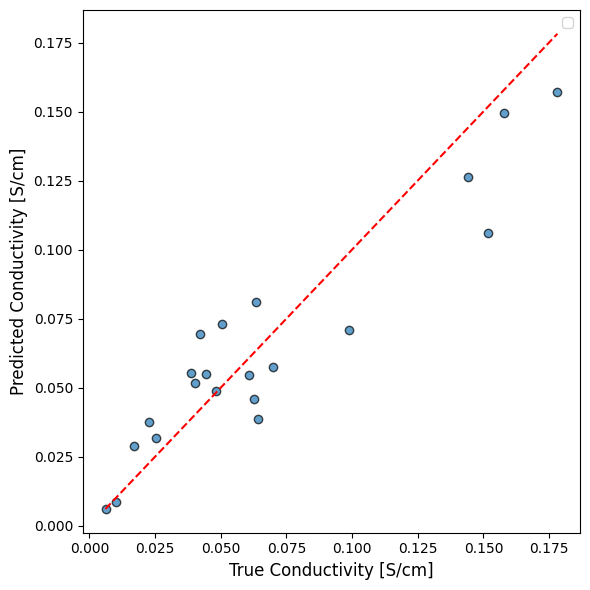

In [16]:
# ==========================================
# 🔹 Parity Plot (Predicted vs Actual)
# ==========================================
plt.figure(figsize=(6, 6))
plt.scatter(y_test_final, y_pred_final, alpha=0.7, edgecolors="k")
lo, hi = min(y_test_final.min(), y_pred_final.min()), max(y_test_final.max(), y_pred_final.max())
plt.plot([lo, hi], [lo, hi], "r--")
plt.xlabel("True Conductivity [S/cm]", fontsize=12)
plt.ylabel("Predicted Conductivity [S/cm]", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


0:	learn: 0.0396547	total: 23ms	remaining: 22.7s
1:	learn: 0.0385315	total: 24.9ms	remaining: 12.3s
2:	learn: 0.0377535	total: 26.7ms	remaining: 8.79s
3:	learn: 0.0371101	total: 28.3ms	remaining: 6.99s
4:	learn: 0.0363974	total: 29.7ms	remaining: 5.87s
5:	learn: 0.0356705	total: 31.1ms	remaining: 5.1s
6:	learn: 0.0348036	total: 32.6ms	remaining: 4.59s
7:	learn: 0.0339366	total: 34ms	remaining: 4.17s
8:	learn: 0.0331641	total: 35.3ms	remaining: 3.85s
9:	learn: 0.0325129	total: 36.7ms	remaining: 3.6s
10:	learn: 0.0317603	total: 38ms	remaining: 3.38s
11:	learn: 0.0312298	total: 38.6ms	remaining: 3.15s
12:	learn: 0.0306289	total: 39.7ms	remaining: 2.98s
13:	learn: 0.0300671	total: 40.8ms	remaining: 2.85s
14:	learn: 0.0296809	total: 42.2ms	remaining: 2.74s
15:	learn: 0.0291961	total: 42.9ms	remaining: 2.61s
16:	learn: 0.0287512	total: 44ms	remaining: 2.52s
17:	learn: 0.0283637	total: 44.8ms	remaining: 2.42s
18:	learn: 0.0279142	total: 45.5ms	remaining: 2.33s
19:	learn: 0.0274909	total: 46.1

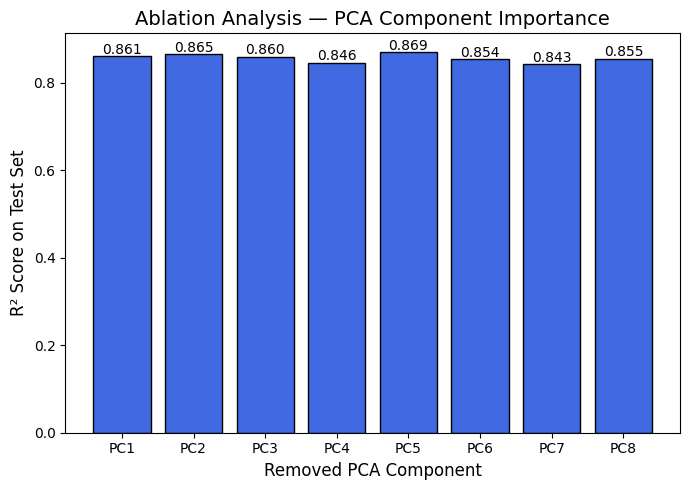

In [38]:
# ==========================================
# 🔍  Ablation Analysis on PCA Components
# ==========================================
ablation_results = []

# Use best RF parameters found by Optuna
best_params = study_cat.best_params

for i in range(X_train_full.shape[1]):  # loop through PCA components
    # Drop the i-th PCA component
    X_train_ablate = np.delete(X_train_full, i, axis=1)
    X_test_ablate = np.delete(X_test_final, i, axis=1)
    
    # Retrain and evaluate
    model = CatBoostRegressor(**best_params)
    model.fit(X_train_ablate, y_train_full)
    y_pred_ablate = model.predict(X_test_ablate)
    r2_ablate = r2_score(y_test_final, y_pred_ablate)
    
    ablation_results.append(r2_ablate)
    print(f"Removed PC{i+1} → R²: {r2_ablate:.4f}")

# Convert to DataFrame
ablation_df = pd.DataFrame({
    "PCA_Component_Removed": [f"PC{i+1}" for i in range(len(ablation_results))],
    "R2_Score": ablation_results
})

# ==========================================
# 📊  Plot Ablation Results (Vertical)
# ==========================================
plt.figure(figsize=(7,5))
bars = plt.bar(range(1, len(ablation_results)+1), ablation_results, color="royalblue", edgecolor="black")

# Annotate R² values above bars
for i, val in enumerate(ablation_results):
    plt.text(i+1, val + 0.005, f"{val:.3f}", ha="center", fontsize=10)

plt.xticks(range(1, len(ablation_results)+1), [f"PC{i}" for i in range(1, len(ablation_results)+1)])
plt.xlabel("Removed PCA Component", fontsize=12)
plt.ylabel("R² Score on Test Set", fontsize=12)
plt.title("Ablation Analysis — PCA Component Importance", fontsize=14)
plt.tight_layout()
plt.show()


0:	learn: 0.0396547	total: 1.27ms	remaining: 1.26s
1:	learn: 0.0385315	total: 3.31ms	remaining: 1.64s
2:	learn: 0.0377535	total: 4.87ms	remaining: 1.6s
3:	learn: 0.0371101	total: 6.98ms	remaining: 1.72s
4:	learn: 0.0363974	total: 8.28ms	remaining: 1.63s
5:	learn: 0.0356705	total: 9.55ms	remaining: 1.57s
6:	learn: 0.0348036	total: 11.1ms	remaining: 1.56s
7:	learn: 0.0339366	total: 12.6ms	remaining: 1.55s
8:	learn: 0.0331641	total: 14.2ms	remaining: 1.55s
9:	learn: 0.0325129	total: 15.7ms	remaining: 1.54s
10:	learn: 0.0317603	total: 17.2ms	remaining: 1.53s
11:	learn: 0.0312298	total: 18.3ms	remaining: 1.5s
12:	learn: 0.0306289	total: 20.1ms	remaining: 1.51s
13:	learn: 0.0300671	total: 21.7ms	remaining: 1.51s
14:	learn: 0.0296809	total: 23.2ms	remaining: 1.51s
15:	learn: 0.0291961	total: 24.6ms	remaining: 1.5s
16:	learn: 0.0287512	total: 25.8ms	remaining: 1.48s
17:	learn: 0.0283637	total: 27.3ms	remaining: 1.48s
18:	learn: 0.0279142	total: 29.5ms	remaining: 1.51s
19:	learn: 0.0274909	tota

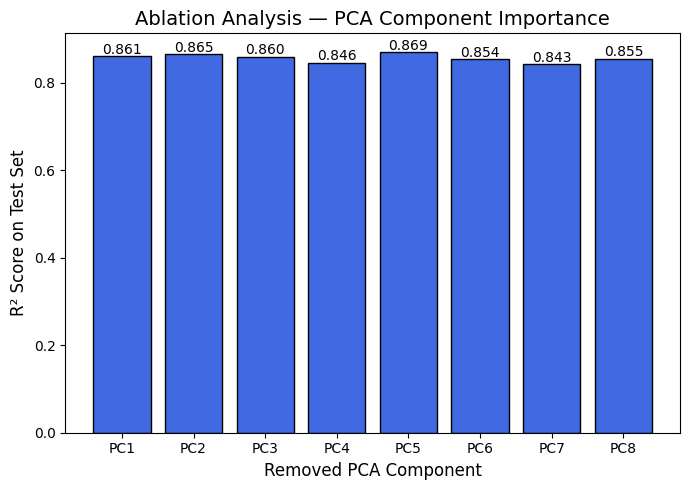

In [17]:
# ==========================================
# 🔍  Ablation Analysis on PCA Components
# ==========================================
ablation_results = []

# Use best RF parameters found by Optuna
best_params = study_cat.best_params

for i in range(X_train_full.shape[1]):  # loop through PCA components
    # Drop the i-th PCA component
    X_train_ablate = np.delete(X_train_full, i, axis=1)
    X_test_ablate = np.delete(X_test_final, i, axis=1)
    
    # Retrain and evaluate
    model = CatBoostRegressor(**best_params)
    model.fit(X_train_ablate, y_train_full)
    y_pred_ablate = model.predict(X_test_ablate)
    r2_ablate = r2_score(y_test_final, y_pred_ablate)
    
    ablation_results.append(r2_ablate)
    print(f"Removed PC{i+1} → R²: {r2_ablate:.4f}")

# Convert to DataFrame
ablation_df = pd.DataFrame({
    "PCA_Component_Removed": [f"PC{i+1}" for i in range(len(ablation_results))],
    "R2_Score": ablation_results
})

# ==========================================
# 📊  Plot Ablation Results (Vertical)
# ==========================================
plt.figure(figsize=(7,5))
bars = plt.bar(range(1, len(ablation_results)+1), ablation_results, color="royalblue", edgecolor="black")

# Annotate R² values above bars
for i, val in enumerate(ablation_results):
    plt.text(i+1, val + 0.005, f"{val:.3f}", ha="center", fontsize=10)

plt.xticks(range(1, len(ablation_results)+1), [f"PC{i}" for i in range(1, len(ablation_results)+1)])
plt.xlabel("Removed PCA Component", fontsize=12)
plt.ylabel("R² Score on Test Set", fontsize=12)
plt.title("Ablation Analysis — PCA Component Importance", fontsize=14)
plt.tight_layout()
plt.show()


### MLP

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.neural_network import MLPRegressor
import optuna
import matplotlib.pyplot as plt
from collections import defaultdict

# ==========================================
# 1️⃣ Load dataset
# ==========================================
data = pd.read_csv("../../data/full_descriptor_data.csv")

target_col = data.columns[-1]
X = data.drop(columns=[target_col])
y = data[target_col]

# ==========================================
# 2️⃣ Standardize + PCA
# ==========================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.80, random_state=2023)
X_pca = pca.fit_transform(X_scaled)

print(f"✅ PCA selected {pca.n_components_} components explaining {pca.explained_variance_ratio_.sum():.2f} variance.")

# ==========================================
# 3️⃣ Split data
# ==========================================
X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(
    X_pca, y, test_size=0.1, random_state=2023
)

# ==========================================
# 4️⃣ Optuna Objective for MLP
# ==========================================
def objective_mlp(trial):
    params = {
        "hidden_layer_sizes": tuple([
            trial.suggest_int("n_units_layer1", 32, 256),
            trial.suggest_int("n_units_layer2", 16, 128)
        ]),
        "activation": trial.suggest_categorical("activation", ["relu", "tanh"]),
        "solver": trial.suggest_categorical("solver", ["adam", "lbfgs"]),
        "alpha": trial.suggest_float("alpha", 1e-5, 1e-1, log=True),
        "learning_rate_init": trial.suggest_float("learning_rate_init", 1e-4, 1e-2, log=True),
        "max_iter": 1000,
        "random_state": 2023,
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=2023)
    r2_scores = []

    for train_idx, val_idx in kf.split(X_train_full):
        X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
        y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        model = MLPRegressor(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        r2_scores.append(r2_score(y_val, y_pred))

    return np.mean(r2_scores)

# ==========================================
# 5️⃣ Run optimization
# ==========================================
study_mlp = optuna.create_study(direction="maximize")
study_mlp.optimize(objective_mlp, n_trials=20, show_progress_bar=True)

# ==========================================
# 6️⃣ Evaluate best model
# ==========================================
print("\n🎯 Best parameters (MLP):")
for k, v in study_mlp.best_params.items():
    print(f"{k}: {v}")
print(f"✅ Best mean CV R²: {study_mlp.best_value:.4f}")

best_model_mlp = MLPRegressor(
    hidden_layer_sizes=(
        study_mlp.best_params["n_units_layer1"],
        study_mlp.best_params["n_units_layer2"],
    ),
    activation=study_mlp.best_params["activation"],
    solver=study_mlp.best_params["solver"],
    alpha=study_mlp.best_params["alpha"],
    learning_rate_init=study_mlp.best_params["learning_rate_init"],
    max_iter=1000,
    random_state=2023
)
best_model_mlp.fit(X_train_full, y_train_full)
y_pred_final = best_model_mlp.predict(X_test_final)

r2 = r2_score(y_test_final, y_pred_final)
mae = mean_absolute_error(y_test_final, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test_final, y_pred_final))

print("\n🧾 Final MLP Evaluation:")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


[I 2025-10-28 15:08:18,388] A new study created in memory with name: no-name-97e87f28-9f74-45a3-8d61-499486314e0f


✅ PCA selected 8 components explaining 0.81 variance.


Best trial: 0. Best value: 0.371635:   5%|▌         | 1/20 [00:02<00:43,  2.26s/it]

[I 2025-10-28 15:08:20,664] Trial 0 finished with value: 0.37163492151862176 and parameters: {'n_units_layer1': 93, 'n_units_layer2': 23, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.024453105859642308, 'learning_rate_init': 0.00015647389661316362}. Best is trial 0 with value: 0.37163492151862176.


Best trial: 0. Best value: 0.371635:  10%|█         | 2/20 [00:02<00:19,  1.07s/it]

[I 2025-10-28 15:08:20,899] Trial 1 finished with value: -8.646763923617579 and parameters: {'n_units_layer1': 32, 'n_units_layer2': 69, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05195364426282282, 'learning_rate_init': 0.0003850328767068197}. Best is trial 0 with value: 0.37163492151862176.


Best trial: 0. Best value: 0.371635:  15%|█▌        | 3/20 [00:04<00:21,  1.28s/it]

[I 2025-10-28 15:08:22,418] Trial 2 finished with value: -4.139052162597573 and parameters: {'n_units_layer1': 138, 'n_units_layer2': 111, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.00012272090830664625, 'learning_rate_init': 0.0012845494162099708}. Best is trial 0 with value: 0.37163492151862176.


Best trial: 3. Best value: 0.555241:  20%|██        | 4/20 [00:05<00:21,  1.34s/it]

[I 2025-10-28 15:08:23,869] Trial 3 finished with value: 0.5552414426864261 and parameters: {'n_units_layer1': 87, 'n_units_layer2': 20, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.022764043522585015, 'learning_rate_init': 0.00014739162343665736}. Best is trial 3 with value: 0.5552414426864261.


Best trial: 3. Best value: 0.555241:  25%|██▌       | 5/20 [00:05<00:14,  1.03it/s]

[I 2025-10-28 15:08:24,172] Trial 4 finished with value: -4.064571441342084 and parameters: {'n_units_layer1': 116, 'n_units_layer2': 109, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0002583062064212278, 'learning_rate_init': 0.0012622127508670968}. Best is trial 3 with value: 0.5552414426864261.


Best trial: 3. Best value: 0.555241:  30%|███       | 6/20 [00:09<00:25,  1.80s/it]

[I 2025-10-28 15:08:27,599] Trial 5 finished with value: 0.48694476612198195 and parameters: {'n_units_layer1': 198, 'n_units_layer2': 61, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.046906253454233264, 'learning_rate_init': 0.0008314664285026367}. Best is trial 3 with value: 0.5552414426864261.


Best trial: 3. Best value: 0.555241:  35%|███▌      | 7/20 [00:10<00:20,  1.60s/it]

[I 2025-10-28 15:08:28,768] Trial 6 finished with value: -3.226383173993767 and parameters: {'n_units_layer1': 172, 'n_units_layer2': 55, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 3.056456931148453e-05, 'learning_rate_init': 0.00020925054713104944}. Best is trial 3 with value: 0.5552414426864261.


Best trial: 3. Best value: 0.555241:  40%|████      | 8/20 [00:19<00:46,  3.85s/it]

[I 2025-10-28 15:08:37,458] Trial 7 finished with value: 0.05850608765842191 and parameters: {'n_units_layer1': 229, 'n_units_layer2': 99, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.014998936158603628, 'learning_rate_init': 0.001022426965780569}. Best is trial 3 with value: 0.5552414426864261.


Best trial: 3. Best value: 0.555241:  45%|████▌     | 9/20 [00:20<00:34,  3.13s/it]

[I 2025-10-28 15:08:38,984] Trial 8 finished with value: -19.543118394974393 and parameters: {'n_units_layer1': 176, 'n_units_layer2': 27, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 1.786470306837648e-05, 'learning_rate_init': 0.0012219662953845485}. Best is trial 3 with value: 0.5552414426864261.


Best trial: 3. Best value: 0.555241:  50%|█████     | 10/20 [00:20<00:22,  2.27s/it]

[I 2025-10-28 15:08:39,332] Trial 9 finished with value: -39.68949247294877 and parameters: {'n_units_layer1': 99, 'n_units_layer2': 89, 'activation': 'relu', 'solver': 'adam', 'alpha': 3.463785765557352e-05, 'learning_rate_init': 0.0011211401252887933}. Best is trial 3 with value: 0.5552414426864261.


Best trial: 3. Best value: 0.555241:  55%|█████▌    | 11/20 [00:21<00:14,  1.65s/it]

[I 2025-10-28 15:08:39,568] Trial 10 finished with value: -8.422866685470465 and parameters: {'n_units_layer1': 42, 'n_units_layer2': 42, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0034383254377008277, 'learning_rate_init': 0.0077263163458308306}. Best is trial 3 with value: 0.5552414426864261.


c:\Users\pnaghs1\AppData\Local\anaconda\envs\mordred\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\pnaghs1\AppData\Local\anaconda\envs\mordred\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\pnaghs1\AppData\Local\anaconda\envs\mordred\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:

[I 2025-10-28 15:08:52,603] Trial 11 finished with value: -3.1866355191610767 and parameters: {'n_units_layer1': 252, 'n_units_layer2': 75, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.002318708484097315, 'learning_rate_init': 0.005425121925367149}. Best is trial 3 with value: 0.5552414426864261.


Best trial: 12. Best value: 0.569861:  65%|██████▌   | 13/20 [00:38<00:33,  4.81s/it]

[I 2025-10-28 15:08:56,709] Trial 12 finished with value: 0.569860874751493 and parameters: {'n_units_layer1': 193, 'n_units_layer2': 44, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.0916657577013717, 'learning_rate_init': 0.0004247467700563827}. Best is trial 12 with value: 0.569860874751493.


Best trial: 12. Best value: 0.569861:  70%|███████   | 14/20 [00:41<00:25,  4.20s/it]

[I 2025-10-28 15:08:59,498] Trial 13 finished with value: 0.05481613594025645 and parameters: {'n_units_layer1': 65, 'n_units_layer2': 41, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.007150729179020675, 'learning_rate_init': 0.00010976740234286593}. Best is trial 12 with value: 0.569860874751493.


Best trial: 14. Best value: 0.589609:  75%|███████▌  | 15/20 [00:41<00:15,  3.20s/it]

[I 2025-10-28 15:09:00,387] Trial 14 finished with value: 0.5896092954650503 and parameters: {'n_units_layer1': 142, 'n_units_layer2': 17, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.0994499407458184, 'learning_rate_init': 0.00039146081673799657}. Best is trial 14 with value: 0.5896092954650503.


Best trial: 15. Best value: 0.593226:  80%|████████  | 16/20 [00:45<00:13,  3.26s/it]

[I 2025-10-28 15:09:03,779] Trial 15 finished with value: 0.5932257172881148 and parameters: {'n_units_layer1': 147, 'n_units_layer2': 44, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.08510943320524421, 'learning_rate_init': 0.0004014869039950088}. Best is trial 15 with value: 0.5932257172881148.


Best trial: 15. Best value: 0.593226:  85%|████████▌ | 17/20 [00:47<00:08,  2.90s/it]

[I 2025-10-28 15:09:05,863] Trial 16 finished with value: -6.982757334263207 and parameters: {'n_units_layer1': 147, 'n_units_layer2': 33, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.0007557271887432609, 'learning_rate_init': 0.0004209488407723558}. Best is trial 15 with value: 0.5932257172881148.


Best trial: 15. Best value: 0.593226:  90%|█████████ | 18/20 [00:51<00:06,  3.22s/it]

[I 2025-10-28 15:09:09,803] Trial 17 finished with value: 0.43372257989626045 and parameters: {'n_units_layer1': 147, 'n_units_layer2': 19, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.007821686778322335, 'learning_rate_init': 0.0026770936864579146}. Best is trial 15 with value: 0.5932257172881148.


Best trial: 15. Best value: 0.593226:  95%|█████████▌| 19/20 [00:51<00:02,  2.38s/it]

[I 2025-10-28 15:09:10,237] Trial 18 finished with value: -67.88121509902814 and parameters: {'n_units_layer1': 124, 'n_units_layer2': 53, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07577364982653867, 'learning_rate_init': 0.00025180947958905426}. Best is trial 15 with value: 0.5932257172881148.


Best trial: 15. Best value: 0.593226: 100%|██████████| 20/20 [00:55<00:00,  2.79s/it]


[I 2025-10-28 15:09:14,236] Trial 19 finished with value: -32.30882017945278 and parameters: {'n_units_layer1': 166, 'n_units_layer2': 34, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.000865080066246084, 'learning_rate_init': 0.0006268694532085897}. Best is trial 15 with value: 0.5932257172881148.

🎯 Best parameters (MLP):
n_units_layer1: 147
n_units_layer2: 44
activation: relu
solver: lbfgs
alpha: 0.08510943320524421
learning_rate_init: 0.0004014869039950088
✅ Best mean CV R²: 0.5932

🧾 Final MLP Evaluation:
R²: 0.8340
MAE: 0.0167
RMSE: 0.0201


### LIGHTGBM

[I 2025-10-28 15:13:45,987] A new study created in memory with name: no-name-9befd9db-4809-4f62-9576-5a15e24a4613


✅ PCA selected 8 components explaining 0.81 variance.


  0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[154]	valid_0's rmse: 0.0263393
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[177]	valid_0's rmse: 0.0346714
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[130]	valid_0's rmse: 0.0305037
Training until validation scores don't improve for 50 rounds


Best trial: 0. Best value: 0.46567:   5%|▌         | 1/20 [00:00<00:13,  1.41it/s]

Early stopping, best iteration is:
[155]	valid_0's rmse: 0.0243136
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	valid_0's rmse: 0.0305041
[I 2025-10-28 15:13:46,680] Trial 0 finished with value: 0.46566998750640887 and parameters: {'n_estimators': 944, 'num_leaves': 71, 'max_depth': 8, 'learning_rate': 0.0632410324242508, 'feature_fraction': 0.7643187317042079, 'bagging_fraction': 0.8928716977146309, 'bagging_freq': 6, 'lambda_l1': 0.14373556755545636, 'lambda_l2': 1.025722074454527, 'min_child_samples': 7}. Best is trial 0 with value: 0.46566998750640887.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0426759
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0445905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0409126
Tra

Best trial: 0. Best value: 0.46567:  15%|█▌        | 3/20 [00:00<00:04,  3.77it/s]

Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0373114
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0388757
[I 2025-10-28 15:13:46,774] Trial 1 finished with value: -0.04028899422613148 and parameters: {'n_estimators': 630, 'num_leaves': 109, 'max_depth': 9, 'learning_rate': 0.07271512230617425, 'feature_fraction': 0.7594280918727868, 'bagging_fraction': 0.6236553487324751, 'bagging_freq': 7, 'lambda_l1': 3.207258083600543, 'lambda_l2': 0.9912887475274867, 'min_child_samples': 29}. Best is trial 0 with value: 0.46566998750640887.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[294]	valid_0's rmse: 0.0353669
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[305]	valid_0's rmse: 0.03999
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[127]	valid_0's rmse: 0.0357404

Best trial: 0. Best value: 0.46567:  30%|███       | 6/20 [00:01<00:02,  6.38it/s]

[I 2025-10-28 15:13:46,949] Trial 3 finished with value: -0.04028899422613148 and parameters: {'n_estimators': 359, 'num_leaves': 27, 'max_depth': 5, 'learning_rate': 0.10967138867386582, 'feature_fraction': 0.9290390195191649, 'bagging_fraction': 0.8491764747576458, 'bagging_freq': 6, 'lambda_l1': 4.017863920255131, 'lambda_l2': 4.940813248885329, 'min_child_samples': 15}. Best is trial 0 with value: 0.46566998750640887.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's rmse: 0.0337473
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[96]	valid_0's rmse: 0.0382907
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[108]	valid_0's rmse: 0.0336375
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	valid_0's rmse: 0.0319382
Training until validation scores don't improve for 50 rounds
Earl

Best trial: 0. Best value: 0.46567:  45%|████▌     | 9/20 [00:01<00:01,  9.81it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[129]	valid_0's rmse: 0.0264091
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	valid_0's rmse: 0.0305595
[I 2025-10-28 15:13:47,178] Trial 7 finished with value: 0.3989888412013349 and parameters: {'n_estimators': 484, 'num_leaves': 74, 'max_depth': 11, 'learning_rate': 0.05544488684892125, 'feature_fraction': 0.8506582954305943, 'bagging_fraction': 0.9789232308404415, 'bagging_freq': 5, 'lambda_l1': 0.20450941376046694, 'lambda_l2': 0.786217718920923, 'min_child_samples': 14}. Best is trial 0 with value: 0.46566998750640887.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0426759
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0445905
Training until validation scores don't improve for 50 rounds
Earl

Best trial: 11. Best value: 0.48548:  55%|█████▌    | 11/20 [00:01<00:00, 12.52it/s]

[I 2025-10-28 15:13:47,329] Trial 10 finished with value: -0.04028899422613148 and parameters: {'n_estimators': 995, 'num_leaves': 45, 'max_depth': 6, 'learning_rate': 0.2746202690759852, 'feature_fraction': 0.6045178317396599, 'bagging_fraction': 0.6968838225887399, 'bagging_freq': 10, 'lambda_l1': 1.7569829935743715, 'lambda_l2': 3.366028315437426, 'min_child_samples': 21}. Best is trial 0 with value: 0.46566998750640887.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[218]	valid_0's rmse: 0.024377
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[146]	valid_0's rmse: 0.0364181
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[216]	valid_0's rmse: 0.0301661
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[215]	valid_0's rmse: 0.0241597
Training until validat

Best trial: 11. Best value: 0.48548:  65%|██████▌   | 13/20 [00:01<00:00, 10.45it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[213]	valid_0's rmse: 0.0401001
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[213]	valid_0's rmse: 0.036059
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[213]	valid_0's rmse: 0.0377499
[I 2025-10-28 15:13:47,597] Trial 12 finished with value: 0.0031483846901074974 and parameters: {'n_estimators': 213, 'num_leaves': 51, 'max_depth': 12, 'learning_rate': 0.03003659799961645, 'feature_fraction': 0.9890007316239737, 'bagging_fraction': 0.9949728403975769, 'bagging_freq': 3, 'lambda_l1': 1.1850240234178984, 'lambda_l2': 0.1581718703051465, 'min_child_samples': 22}. Best is trial 11 with value: 0.4854803519876043.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[108]	valid_0's rmse: 0.0248865
Training until vali

Best trial: 11. Best value: 0.48548:  75%|███████▌  | 15/20 [00:01<00:00, 10.47it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.0408384
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[125]	valid_0's rmse: 0.0364999
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's rmse: 0.038749
[I 2025-10-28 15:13:47,789] Trial 14 finished with value: -0.020052358941148474 and parameters: {'n_estimators': 209, 'num_leaves': 60, 'max_depth': 9, 'learning_rate': 0.02871633088047144, 'feature_fraction': 0.7002840721189676, 'bagging_fraction': 0.9403683835589323, 'bagging_freq': 7, 'lambda_l1': 1.2837562127898345, 'lambda_l2': 0.10640263240268344, 'min_child_samples': 5}. Best is trial 11 with value: 0.4854803519876043.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[423]	valid_0's rmse: 0.0419723
Training until validation scores don't improve for 50 rounds
D

Best trial: 11. Best value: 0.48548:  85%|████████▌ | 17/20 [00:02<00:00,  9.31it/s]

Did not meet early stopping. Best iteration is:
[319]	valid_0's rmse: 0.0381726
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[165]	valid_0's rmse: 0.0415767
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[313]	valid_0's rmse: 0.0365609
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[110]	valid_0's rmse: 0.0355702
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[281]	valid_0's rmse: 0.0351896
[I 2025-10-28 15:13:48,060] Trial 16 finished with value: 0.12522045609450422 and parameters: {'n_estimators': 319, 'num_leaves': 20, 'max_depth': 10, 'learning_rate': 0.0413608423075133, 'feature_fraction': 0.718829975078954, 'bagging_fraction': 0.8606391378933758, 'bagging_freq': 4, 'lambda_l1': 0.7714338321073531, 'lambda_l2': 1.4976227972638099, 'min_child_samples': 25}. Best

Best trial: 11. Best value: 0.48548: 100%|██████████| 20/20 [00:02<00:00,  8.01it/s]

[I 2025-10-28 15:13:48,409] Trial 18 finished with value: 0.4381021443017379 and parameters: {'n_estimators': 773, 'num_leaves': 43, 'max_depth': 7, 'learning_rate': 0.01104922578150481, 'feature_fraction': 0.6291654516397138, 'bagging_fraction': 0.8325396215176067, 'bagging_freq': 4, 'lambda_l1': 0.018774506277287537, 'lambda_l2': 2.547557578865439, 'min_child_samples': 19}. Best is trial 11 with value: 0.4854803519876043.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0426759
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0445905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0409126
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0373114
Training until validation scores don't improve for 50 rounds
Early s

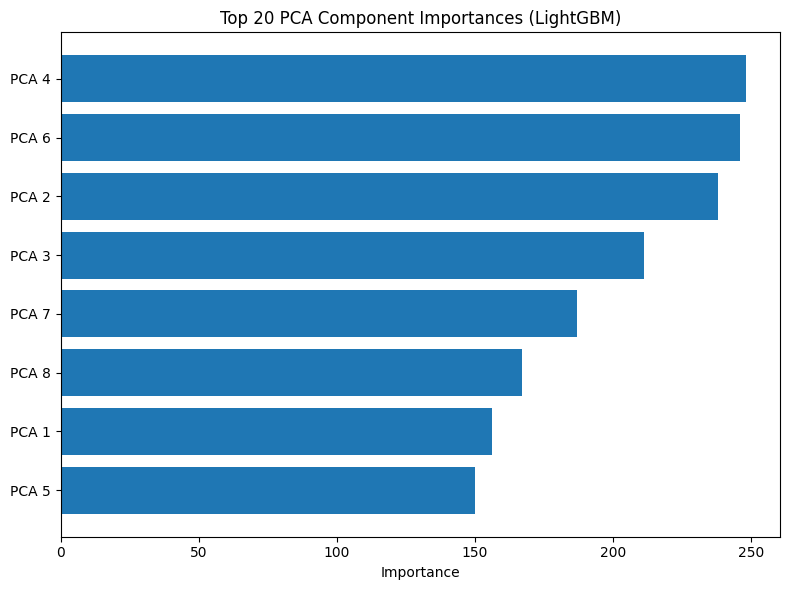

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import optuna
import matplotlib.pyplot as plt

# ==========================================
# 1️⃣ Load dataset
# ==========================================
data = pd.read_csv("../../data/full_descriptor_data.csv")

target_col = data.columns[-1]
X = data.drop(columns=[target_col])
y = data[target_col]

# ==========================================
# 2️⃣ Standardize + PCA
# ==========================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.80, random_state=2023)
X_pca = pca.fit_transform(X_scaled)

print(f"✅ PCA selected {pca.n_components_} components explaining {pca.explained_variance_ratio_.sum():.2f} variance.")

# ==========================================
# 3️⃣ Split data
# ==========================================
X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(
    X_pca, y, test_size=0.1, random_state=2023
)

# ==========================================
# 4️⃣ Optuna Objective for LightGBM
# ==========================================
def objective_lgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "num_leaves": trial.suggest_int("num_leaves", 20, 120),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 5.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 5.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 30),
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "random_state": 2023,
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=2023)
    r2_scores = []

    for train_idx, val_idx in kf.split(X_train_full):
        X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
        y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        model = LGBMRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric="rmse",
            callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=0)]
        )

        y_pred = model.predict(X_val)
        r2_scores.append(r2_score(y_val, y_pred))

    return np.mean(r2_scores)

# ==========================================
# 5️⃣ Run optimization
# ==========================================
study_lgb = optuna.create_study(direction="maximize")
study_lgb.optimize(objective_lgb, n_trials=20, show_progress_bar=True)

# ==========================================
# 6️⃣ Evaluate best model
# ==========================================
print("\n🎯 Best parameters (LightGBM):")
for k, v in study_lgb.best_params.items():
    print(f"{k}: {v}")
print(f"✅ Best mean CV R²: {study_lgb.best_value:.4f}")

best_model_lgb = LGBMRegressor(**study_lgb.best_params, random_state=2023)
best_model_lgb.fit(X_train_full, y_train_full)
y_pred_final = best_model_lgb.predict(X_test_final)

r2 = r2_score(y_test_final, y_pred_final)
mae = mean_absolute_error(y_test_final, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test_final, y_pred_final))

print("\n🧾 Final LightGBM Evaluation:")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# ==========================================
# 7️⃣ Feature Importance Plot (Optional)
# ==========================================
importances = best_model_lgb.feature_importances_
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), [f"PCA {i+1}" for i in indices[::-1]])
plt.xlabel("Importance")
plt.title("Top 20 PCA Component Importances (LightGBM)")
plt.tight_layout()
plt.show()


In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet  # change to Ridge, Lasso, or LinearRegression if desired
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import optuna

# 1) Load
data = pd.read_csv("../../data/full_descriptor_data.csv")
target_col = data.columns[-1]
X = data.drop(columns=[target_col])
y = data[target_col]

# 2) Standardize + PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.80, random_state=2023)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA: {pca.n_components_} comps, var={pca.explained_variance_ratio_.sum():.2f}")

# 3) Split
X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(
    X_pca, y, test_size=0.1, random_state=2023
)

# 4) Optuna objective for ElasticNet only
def objective_en(trial):
    alpha = trial.suggest_float("alpha", 1e-5, 10.0, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)  # 0=L2 (ridge-like), 1=L1 (lasso-like)
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=2023, max_iter=10000)

    kf = KFold(n_splits=5, shuffle=True, random_state=2023)
    r2_scores = []
    for tr, va in kf.split(X_train_full):
        X_tr, X_va = X_train_full[tr], X_train_full[va]
        y_tr, y_va = y_train_full.iloc[tr], y_train_full.iloc[va]
        model.fit(X_tr, y_tr)
        y_hat = model.predict(X_va)
        r2_scores.append(r2_score(y_va, y_hat))
    return float(np.mean(r2_scores))

# 5) Optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective_en, n_trials=30, show_progress_bar=True)

print("\nBest ElasticNet params:", study.best_params)
print("Best mean CV R²:", f"{study.best_value:.4f}")

# 6) Final fit & test metrics
best = ElasticNet(
    alpha=study.best_params["alpha"],
    l1_ratio=study.best_params["l1_ratio"],
    random_state=2023,
    max_iter=10000,
)
best.fit(X_train_full, y_train_full)
y_pred = best.predict(X_test_final)

r2 = r2_score(y_test_final, y_pred)
mae = mean_absolute_error(y_test_final, y_pred)
rmse = mean_squared_error(y_test_final, y_pred, squared=False)

print("\nFinal ElasticNet Evaluation:")
print("R²:", f"{r2:.4f}")
print("MAE:", f"{mae:.4f}")
print("RMSE:", f"{rmse:.4f}")


[I 2025-10-28 15:18:43,932] A new study created in memory with name: no-name-db25551e-dca7-4cc6-a92f-dd3844382e67


PCA: 8 comps, var=0.81


Best trial: 9. Best value: 0.213206:  57%|█████▋    | 17/30 [00:00<00:00, 118.57it/s]

[I 2025-10-28 15:18:43,948] Trial 0 finished with value: 0.1719929087986155 and parameters: {'alpha': 0.00034954336521101856, 'l1_ratio': 0.07574476126073504}. Best is trial 0 with value: 0.1719929087986155.
[I 2025-10-28 15:18:43,948] Trial 1 finished with value: 0.17185470771068853 and parameters: {'alpha': 0.00010561404388129207, 'l1_ratio': 0.013033848770437562}. Best is trial 0 with value: 0.1719929087986155.
[I 2025-10-28 15:18:43,962] Trial 2 finished with value: -0.04028899444363301 and parameters: {'alpha': 4.6145284049465225, 'l1_ratio': 0.7996666920805977}. Best is trial 0 with value: 0.1719929087986155.
[I 2025-10-28 15:18:43,969] Trial 3 finished with value: 0.17567296664664298 and parameters: {'alpha': 0.0023712745653586055, 'l1_ratio': 0.30452083110153716}. Best is trial 3 with value: 0.17567296664664298.
[I 2025-10-28 15:18:43,976] Trial 4 finished with value: 0.12662660860824998 and parameters: {'alpha': 0.12990749858179035, 'l1_ratio': 0.3382215832489939}. Best is tri

Best trial: 9. Best value: 0.213206:  63%|██████▎   | 19/30 [00:00<00:00, 118.57it/s]

[I 2025-10-28 15:18:44,115] Trial 18 finished with value: -0.04028899444363301 and parameters: {'alpha': 0.4250079088075397, 'l1_ratio': 0.6479801826477783}. Best is trial 9 with value: 0.21320572361488432.
[I 2025-10-28 15:18:44,117] Trial 19 finished with value: 0.20040909173530955 and parameters: {'alpha': 0.02627415870814654, 'l1_ratio': 0.2632571795778491}. Best is trial 9 with value: 0.21320572361488432.


Best trial: 21. Best value: 0.213543: 100%|██████████| 30/30 [00:00<00:00, 99.34it/s] 

[I 2025-10-28 15:18:44,136] Trial 20 finished with value: 0.1795035203501871 and parameters: {'alpha': 0.0027420055196127014, 'l1_ratio': 0.5420368672115304}. Best is trial 9 with value: 0.21320572361488432.
[I 2025-10-28 15:18:44,153] Trial 21 finished with value: 0.2135425217366687 and parameters: {'alpha': 0.01393447117447454, 'l1_ratio': 0.9928829783991233}. Best is trial 21 with value: 0.2135425217366687.
[I 2025-10-28 15:18:44,164] Trial 22 finished with value: 0.17663027742098852 and parameters: {'alpha': 0.0009993052772571777, 'l1_ratio': 0.9111062609846614}. Best is trial 21 with value: 0.2135425217366687.
[I 2025-10-28 15:18:44,169] Trial 23 finished with value: -0.04028899444363301 and parameters: {'alpha': 0.20342094313070205, 'l1_ratio': 0.9801442763388402}. Best is trial 21 with value: 0.2135425217366687.
[I 2025-10-28 15:18:44,183] Trial 24 finished with value: 0.20922869666132624 and parameters: {'alpha': 0.029873214507736563, 'l1_ratio': 0.747914431949666}. Best is tri

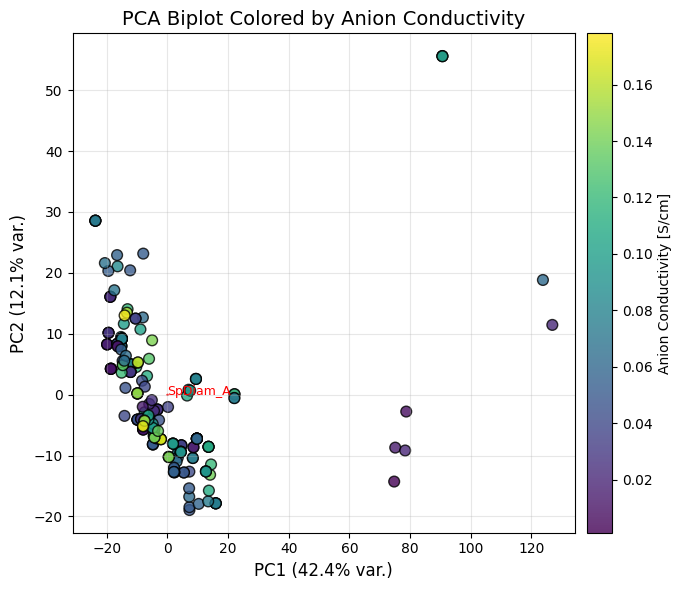

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------
# Project PCA components for visualization
# -------------------------------------------
X_proj = X_pca[:, :2]  # First two principal components
pc1_var, pc2_var = pca.explained_variance_ratio_[:2] * 100

plt.figure(figsize=(7,6))
sc = plt.scatter(
    X_proj[:, 0], X_proj[:, 1],
    c=y, cmap='viridis', s=60, edgecolor='k', alpha=0.8
)
plt.colorbar(sc, label="Anion Conductivity [S/cm]", pad=0.02)
plt.xlabel(f"PC1 ({pc1_var:.1f}% var.)", fontsize=12)
plt.ylabel(f"PC2 ({pc2_var:.1f}% var.)", fontsize=12)
plt.title("PCA Biplot Colored by Anion Conductivity", fontsize=14)
plt.grid(alpha=0.3)

# Optionally overlay loading vectors (top 5)
n_vectors = 5
loadings = pca.components_.T[:, :2]
for i in range(n_vectors):
    plt.arrow(0, 0, loadings[i, 0]*2, loadings[i, 1]*2,
              color='red', alpha=0.5, head_width=0.05)
plt.text(loadings[i,0]*2.1, loadings[i,1]*2.1,
         X.columns[i], color='red', fontsize=9)

plt.tight_layout()
plt.show()


In [20]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------
# 1️⃣ Fit K-Means in PCA space
# -------------------------------------------
k = 2  # You can optimize this via silhouette score
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# -------------------------------------------
# 2️⃣ Add results to a DataFrame for plotting
# -------------------------------------------
df_pca = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])
df_pca['Conductivity'] = y.values
df_pca['Cluster'] = clusters

# -------------------------------------------
# 3️⃣ Plot Clusters in PCA Space
# -------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_pca,
    x='PC1', y='PC2',
    hue='Cluster', palette='tab10', s=60, alpha=0.8, edgecolor='k'
)
plt.scatter(
    kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
    c='black', s=200, marker='X', label='Centroids'
)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var.)", fontsize=12)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var.)", fontsize=12)
plt.title("K-Means Clustering in PCA Space", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------------------------------
# 4️⃣ Analyze Cluster Conductivity
# -------------------------------------------
cluster_summary = df_pca.groupby("Cluster")["Conductivity"].agg(["mean", "std", "count"]).sort_values("mean", ascending=False)
print("\n📊 Cluster Conductivity Summary:")
print(cluster_summary)


c:\Users\pnaghs1\AppData\Local\anaconda\envs\mordred\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pnaghs1\AppData\Local\anaconda\envs\mordred\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



📊 Cluster Conductivity Summary:
             mean       std  count
Cluster                           
0        0.065133  0.041759    198
1        0.038951  0.035075      9


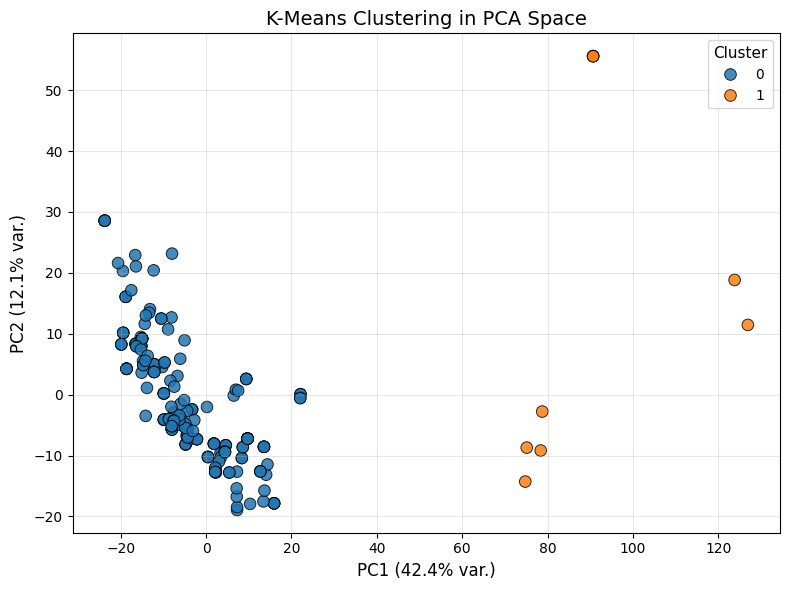

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_pca,
    x="PC1", y="PC2",
    hue="Cluster",                # color by cluster ID
    palette="tab10",              # 10 bright, distinct colors
    s=70, alpha=0.85, edgecolor="k"
)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var.)", fontsize=12)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var.)", fontsize=12)
plt.title("K-Means Clustering in PCA Space", fontsize=14)
plt.legend(title="Cluster", title_fontsize=11, fontsize=10, loc="best")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


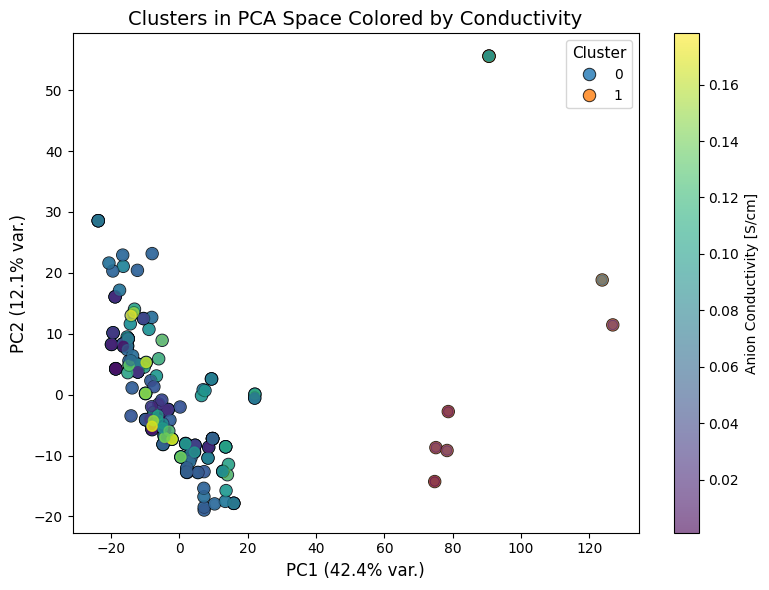

In [22]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_pca,
    x="PC1", y="PC2",
    hue="Cluster", palette="tab10",
    s=80, alpha=0.8, edgecolor="k"
)

sc = plt.scatter(
    df_pca["PC1"], df_pca["PC2"],
    c=df_pca["Conductivity"], cmap="viridis",
    s=50, alpha=0.6
)

plt.colorbar(sc, label="Anion Conductivity [S/cm]")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var.)", fontsize=12)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var.)", fontsize=12)
plt.title("Clusters in PCA Space Colored by Conductivity", fontsize=14)
plt.legend(title="Cluster", title_fontsize=11, fontsize=10, loc="best")
plt.tight_layout()
plt.show()


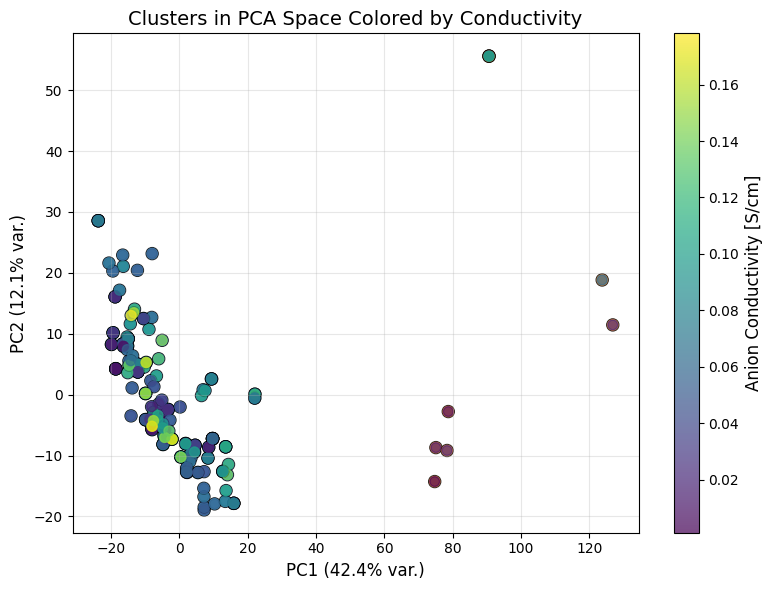

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

# Scatter plot (cluster structure but hide legend)
sns.scatterplot(
    data=df_pca,
    x="PC1", y="PC2",
    hue="Cluster",
    palette="tab10",
    s=80, alpha=0.8, edgecolor="k",
    legend=False  # 🚫 removes cluster legend
)

# Overlay conductivity color mapping
sc = plt.scatter(
    df_pca["PC1"], df_pca["PC2"],
    c=df_pca["Conductivity"],
    cmap="viridis",
    s=50, alpha=0.7
)

# Add colorbar for conductivity
cbar = plt.colorbar(sc)
cbar.set_label("Anion Conductivity [S/cm]", fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Axis labels and title
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var.)", fontsize=12)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var.)", fontsize=12)
plt.title("Clusters in PCA Space Colored by Conductivity", fontsize=14)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


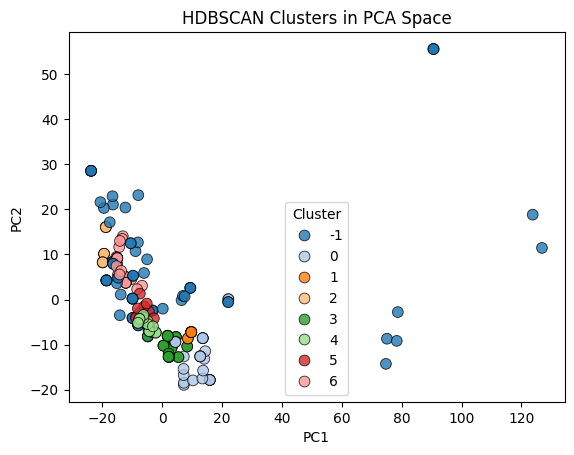

In [24]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=8)
labels = clusterer.fit_predict(X_pca)

df_pca["Cluster"] = labels

sns.scatterplot(
    data=df_pca, x="PC1", y="PC2",
    hue="Cluster", palette="tab20", s=60, alpha=0.8, edgecolor="k"
)
plt.title("HDBSCAN Clusters in PCA Space")
plt.show()


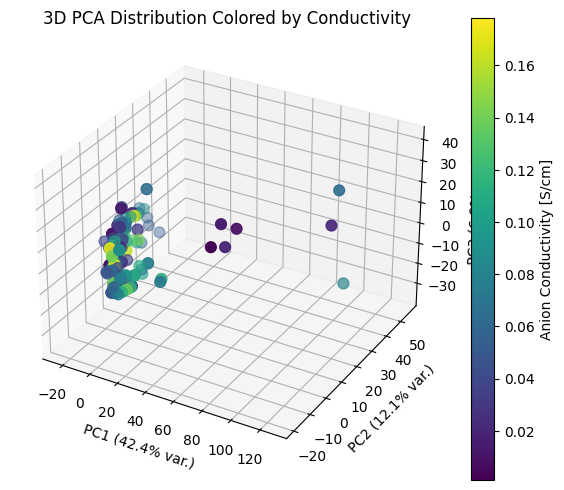

In [25]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=y, cmap='viridis', s=60)
fig.colorbar(p, label="Anion Conductivity [S/cm]")
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var.)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var.)")
ax.set_zlabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}% var.)")
plt.title("3D PCA Distribution Colored by Conductivity")
plt.show()


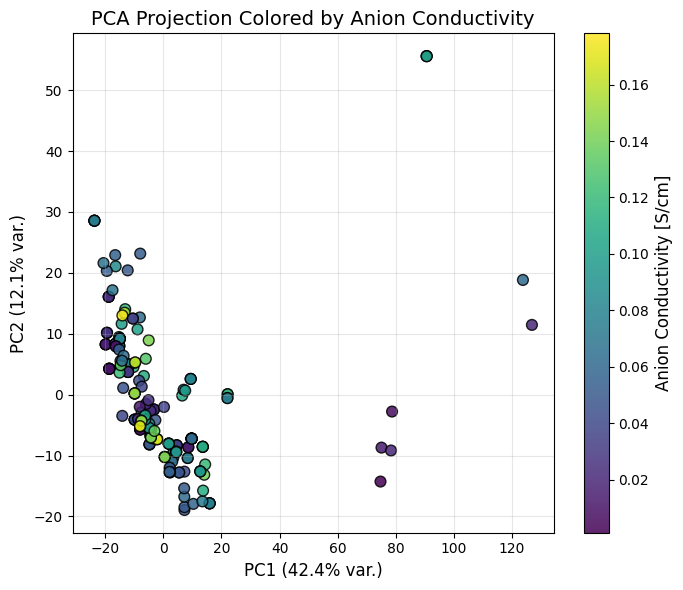

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,6))

# Scatter plot (PC1 vs PC2) colored by conductivity
sc = plt.scatter(
    X_pca[:,0], X_pca[:,1],
    c=y, cmap='viridis', s=60, alpha=0.85, edgecolor='k'
)

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label("Anion Conductivity [S/cm]", fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Axis labels and title
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var.)", fontsize=12)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var.)", fontsize=12)
plt.title("PCA Projection Colored by Anion Conductivity", fontsize=14)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


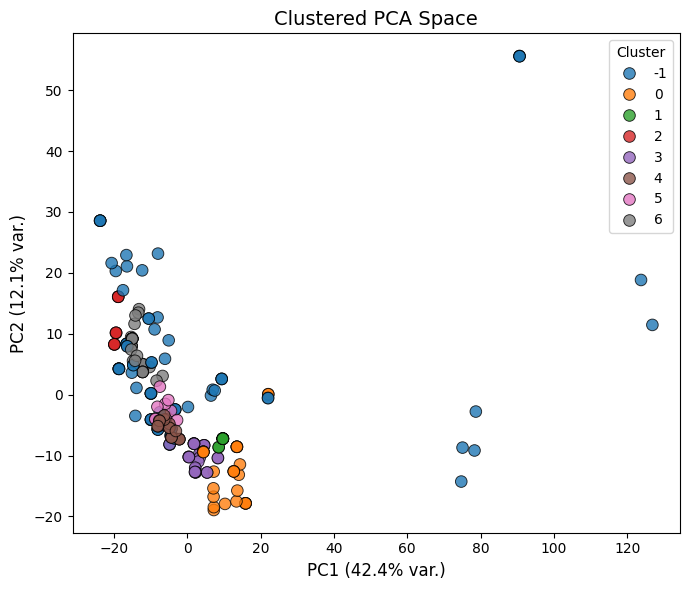

In [27]:
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=df_pca, x="PC1", y="PC2",
    hue="Cluster", palette="tab10", s=70, alpha=0.8, edgecolor="k"
)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var.)", fontsize=12)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var.)", fontsize=12)
plt.title("Clustered PCA Space", fontsize=14)
plt.legend(title="Cluster", fontsize=10)
plt.tight_layout()
plt.show()


In [28]:
# 📊 Summarize conductivity statistics per cluster
cluster_summary = (
    df_pca.groupby("Cluster")["Conductivity"]
    .agg(["min", "max", "mean", "std", "count"])
    .sort_values("mean", ascending=False)
)

# Compute range explicitly for clarity
cluster_summary["range"] = cluster_summary["max"] - cluster_summary["min"]

# Round for nice display
cluster_summary = cluster_summary.round(4)

print("\n📘 Conductivity Range per Cluster:")
print(cluster_summary)



📘 Conductivity Range per Cluster:
            min     max    mean     std  count   range
Cluster                                               
 4       0.0651  0.1782  0.1326  0.0334     15  0.1131
 0       0.0320  0.1400  0.0734  0.0289     27  0.1080
 6       0.0012  0.1752  0.0654  0.0395     32  0.1740
 3       0.0068  0.1467  0.0615  0.0295     28  0.1399
-1       0.0013  0.1650  0.0593  0.0432     75  0.1637
 1       0.0121  0.0758  0.0483  0.0191     11  0.0637
 5       0.0055  0.0466  0.0264  0.0140     10  0.0411
 2       0.0130  0.0493  0.0247  0.0110      9  0.0363


C:\Users\pnaghs1\AppData\Local\Temp\ipykernel_201124\2574218796.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_pca, x="Cluster", y="Conductivity", palette="viridis")


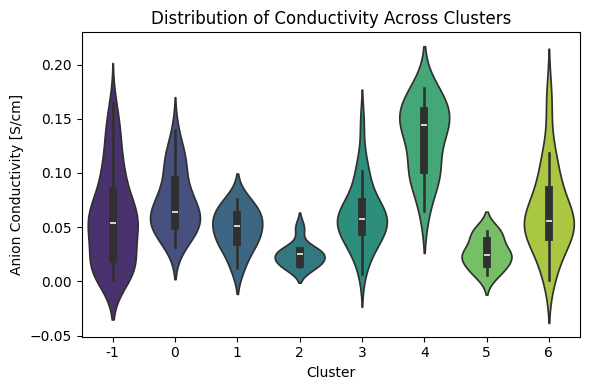

In [29]:
import seaborn as sns, matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.violinplot(data=df_pca, x="Cluster", y="Conductivity", palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Anion Conductivity [S/cm]")
plt.title("Distribution of Conductivity Across Clusters")
plt.tight_layout()
plt.show()


<Axes: xlabel='PC1', ylabel='PC2'>

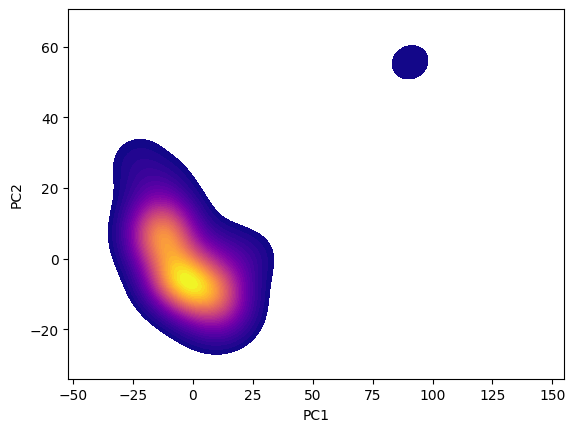

In [30]:
sns.kdeplot(x=df_pca["PC1"], y=df_pca["PC2"],
            weights=df_pca["Conductivity"],
            fill=True, cmap="plasma", levels=40)


C:\Users\pnaghs1\AppData\Local\Temp\ipykernel_201124\2992438580.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\pnaghs1\AppData\Local\Temp\ipykernel_201124\2992438580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


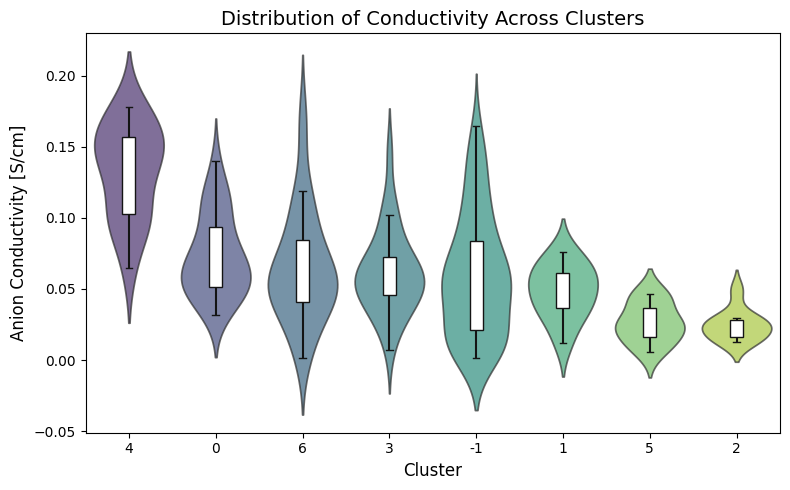

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- Optional sorting by mean conductivity (for nicer visual order)
cluster_order = df_pca.groupby("Cluster")["Conductivity"].mean().sort_values(ascending=False).index

# --- Combined Violin + Boxplot
plt.figure(figsize=(8,5))
sns.violinplot(
    data=df_pca,
    x="Cluster", y="Conductivity",
    order=cluster_order,
    palette="viridis", inner=None, alpha=0.7
)
sns.boxplot(
    data=df_pca,
    x="Cluster", y="Conductivity",
    order=cluster_order,
    width=0.15, boxprops={"zorder":3, "facecolor":"white"},
    showcaps=True, showfliers=False, whiskerprops={"linewidth":1.5},
    palette="Greys"
)

plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Anion Conductivity [S/cm]", fontsize=12)
plt.title("Distribution of Conductivity Across Clusters", fontsize=14)
plt.tight_layout()
plt.show()
